<a href="https://colab.research.google.com/github/ChizobaNzeakor/lagos-waste-analysis/blob/main/ikeja_street_network_accessibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx geopandas folium

In [ ]:
import osmnx as ox
import geopandas as gpd
import folium

# Set logging options manually (new versions don’t use ox.config)
ox.settings.log_console = True
ox.settings.use_cache = True

# Define area of interest
place_name = "Lagos, Nigeria"

In [ ]:
place_name = "Surulere, Lagos, Nigeria"
G = ox.graph_from_place(place_name, network_type='drive')

In [ ]:
import pandas as pd

# Load the uploaded Excel file
file_path = "LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to identify where the illegal dumpsites are listed
xls.sheet_names

['final_verified_dumpsites_lagos_']

In [ ]:
import pandas as pd

# Re-import after code execution reset
file_path = "LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx"
xls = pd.ExcelFile(file_path)

# Show available sheet names
xls.sheet_names

['final_verified_dumpsites_lagos_']

In [ ]:
# Load the data from the relevant sheet
df_illegal = xls.parse('final_verified_dumpsites_lagos_')

# Show the first few rows to understand the structure
df_illegal.head()

Name  Latitude  Longitude  \
0  Amuwo-Odofin    6.4663     3.3015   
1         Ijora    6.4681     3.3795   
2        Mile 2    6.4640     3.3430   
3   Berger Suya    6.4655     3.3448   
4       Anthony    6.5569     3.3673   

                                      Reference Link  
0  https://www.vanguardngr.com/2021/10/lawma-vows...  
1  https://businessday.ng/real-estate/article/n20...  
2  https://pmnewsnigeria.com/2025/02/04/lawma-cra...  
3  https://www.vanguardngr.com/2020/11/abandoned-...  
4  https://guardian.ng/property/lagos-clamps-down...

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Convert to GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in zip(df_illegal['Latitude'], df_illegal['Longitude'])]
gdf_illegal = gpd.GeoDataFrame(df_illegal, geometry=geometry, crs="EPSG:4326")

# Preview
gdf_illegal.head()

Name  Latitude  Longitude  \
0  Amuwo-Odofin    6.4663     3.3015   
1         Ijora    6.4681     3.3795   
2        Mile 2    6.4640     3.3430   
3   Berger Suya    6.4655     3.3448   
4       Anthony    6.5569     3.3673   

                                      Reference Link               geometry  
0  https://www.vanguardngr.com/2021/10/lawma-vows...  POINT (3.3015 6.4663)  
1  https://businessday.ng/real-estate/article/n20...  POINT (3.3795 6.4681)  
2  https://pmnewsnigeria.com/2025/02/04/lawma-cra...    POINT (3.343 6.464)  
3  https://www.vanguardngr.com/2020/11/abandoned-...  POINT (3.3448 6.4655)  
4  https://guardian.ng/property/lagos-clamps-down...  POINT (3.3673 6.5569)

In [ ]:
import folium

# Center the map around the dumpsites
center = [gdf_illegal['Latitude'].mean(), gdf_illegal['Longitude'].mean()]
m = folium.Map(location=center, zoom_start=11)

# Add each dumpsite as a marker
for i, row in gdf_illegal.iterrows():
folium.Marker(
location=[row['Latitude'], row['Longitude']],
popup=row['Name'],
icon=folium.Icon(color='red', icon='trash')
).add_to(m)

m

In [ ]:
# Project to UTM for metric buffering
gdf_illegal_proj = gdf_illegal.to_crs(epsg=32631)

# Create 500m buffer
gdf_illegal_proj['buffer_500m'] = gdf_illegal_proj.buffer(500)

# Convert back to WGS84 for visualization
gdf_illegal_buffered = gdf_illegal_proj.set_geometry('buffer_500m').to_crs(epsg=4326)

# Add buffer zones to map
for geom in gdf_illegal_buffered.geometry:
folium.GeoJson(geom, style_function=lambda x: {'color': 'blue', 'fillOpacity': 0.1}).add_to(m)

m

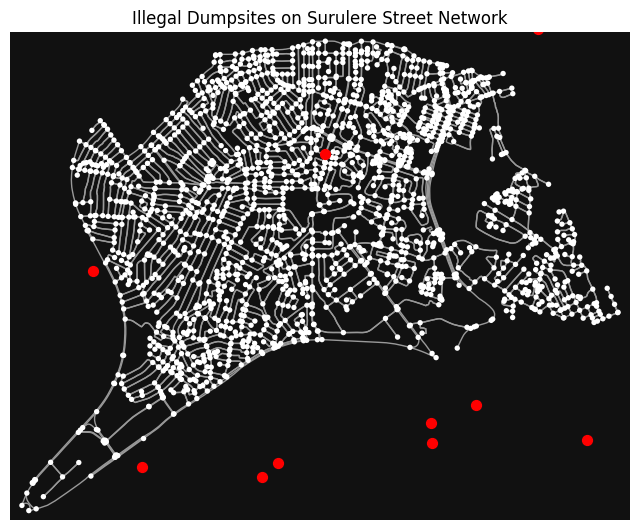

In [ ]:
# Make sure G (your OSM graph for Surulere) is already loaded
import osmnx as ox

# Convert dumpsites to same CRS as street graph
gdf_illegal_utm = gdf_illegal.to_crs(ox.graph_to_gdfs(G, nodes=False).crs)

# Show illegal dumpsites on top of the OSM street map
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(G, show=False, close=False)
gdf_illegal_utm.plot(ax=ax, color='red', markersize=50)
plt.title("Illegal Dumpsites on Surulere Street Network")
plt.show()

In [ ]:
import networkx as nx
from shapely.geometry import Point
import osmnx as ox

# Ensure you have your Surulere graph (G) and illegal dumpsites (gdf_illegal)
# Step 1: Get the nearest network node for each illegal dumpsite
gdf_illegal['nearest_node'] = gdf_illegal.apply(
lambda row: ox.distance.nearest_nodes(G, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

# Optional: preview node IDs
gdf_illegal[['Name', 'nearest_node']].head()

Name  nearest_node
0  Amuwo-Odofin    1475383904
1         Ijora    1047195936
2        Mile 2    2840292857
3   Berger Suya    1790021456
4       Anthony    5576249387

In [ ]:
# Create a list of (x, y) coordinates for each snapped node
node_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in gdf_illegal['nearest_node']]

In [ ]:
from shapely.geometry import Point
import geopandas as gpd

snapped_points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in node_coords], crs="EPSG:4326")

In [ ]:
# Dictionary to store service zones
service_zones = {}

for node in gdf_illegal['nearest_node']:
# Use Dijkstra's algorithm to get all nodes within 500m
reachable_nodes = nx.single_source_dijkstra_path_length(G, node, cutoff=500)
service_zones[node] = list(reachable_nodes.keys())

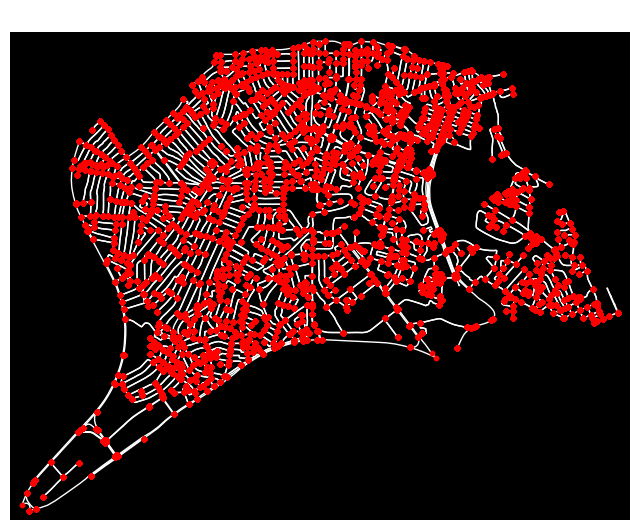

In [ ]:
import matplotlib.pyplot as plt

# Plot base graph
fig, ax = ox.plot_graph(G, node_size=2, edge_color='white', node_color='white', bgcolor='black', show=False, close=False)

# For each service zone, highlight the nodes in red
for zone_nodes in service_zones.values():
zone_xy = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in zone_nodes]
xs, ys = zip(*zone_xy)
ax.scatter(xs, ys, c='red', s=10)

plt.title("500m Street Network Reach from Illegal Dumpsites", color='white')
plt.show()

In [ ]:
import pandas as pd

# Re-load the re-uploaded CSV
df_legal = pd.read_csv("legal_waste_dumpsites.csv", encoding='utf-8-sig')
df_legal.head()

Name  Latitude  Longitude
0                                    Alakija, Festac    6.4671     3.3194
1   32, Wale Azeez street, Ajasa Command White House    6.6097     3.2763
2  Michael Ogun street, Off itire road, Obele Oni...    6.5103     3.3619
3              Adeyole street, liko bustop, Surulere    6.5035     3.3597
4                Asuku street, Ijaiye Ojokoro, Lagos    6.6634     3.2793

In [ ]:
# Snap each legal site to the nearest node in the graph
gdf_legal['nearest_node'] = gdf_legal.apply(
lambda row: ox.distance.nearest_nodes(G, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

In [ ]:
# Store legal service zones
legal_service_zones = {}

for node in gdf_legal['nearest_node']:
reachable_nodes = nx.single_source_dijkstra_path_length(G, node, cutoff=500)
legal_service_zones[node] = list(reachable_nodes.keys())

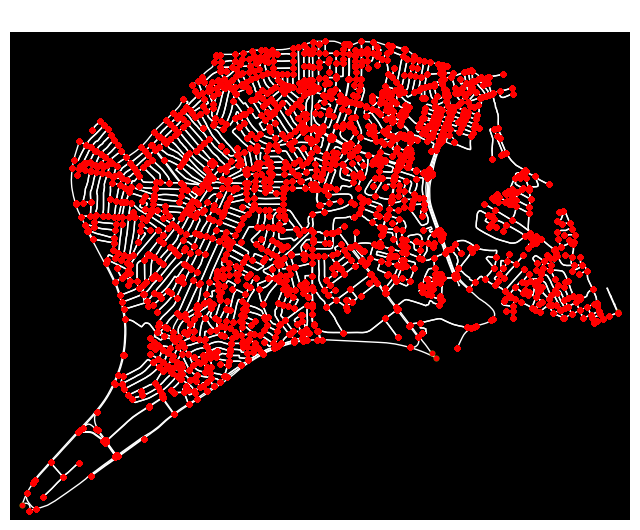

In [ ]:
# Plot the base street graph
fig, ax = ox.plot_graph(G, node_size=2, edge_color='white', node_color='white', bgcolor='black', show=False, close=False)

# Plot legal site service zones (in green)
for nodes in legal_service_zones.values():
coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='lime', s=10, label='Legal Zone')

# Plot illegal site service zones (in red)
for nodes in service_zones.values():
coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='red', s=10, label='Illegal Zone')

plt.title("Network Coverage: Legal (Green) vs Illegal (Red) Waste Sites", color='white')
plt.show()

In [ ]:
import osmnx as ox

place = "Ikeja, Lagos, Nigeria"
G_ikeja = ox.graph_from_place(place, network_type='drive')

In [ ]:
from shapely.geometry import box

# Get bounds from Ikeja graph
nodes_ikeja, _ = ox.graph_to_gdfs(G_ikeja)
bounds = nodes_ikeja.total_bounds  # [minx, miny, maxx, maxy]
ikeja_bbox = box(*bounds)

# Filter both dumpsite sets
gdf_illegal_ikeja = gdf_illegal[gdf_illegal.geometry.within(ikeja_bbox)]
gdf_legal_ikeja = gdf_legal[gdf_legal.geometry.within(ikeja_bbox)]

In [ ]:
# Snap illegal dumpsites in Ikeja
gdf_illegal_ikeja['nearest_node'] = gdf_illegal_ikeja.apply(
lambda row: ox.distance.nearest_nodes(G_ikeja, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

# Snap legal dumpsites in Ikeja
gdf_legal_ikeja['nearest_node'] = gdf_legal_ikeja.apply(
lambda row: ox.distance.nearest_nodes(G_ikeja, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import networkx as nx

# Illegal service zones
illegal_service_ikeja = {}
for node in gdf_illegal_ikeja['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_ikeja, node, cutoff=500)
illegal_service_ikeja[node] = list(reachable.keys())

# Legal service zones
legal_service_ikeja = {}
for node in gdf_legal_ikeja['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_ikeja, node, cutoff=500)
legal_service_ikeja[node] = list(reachable.keys())

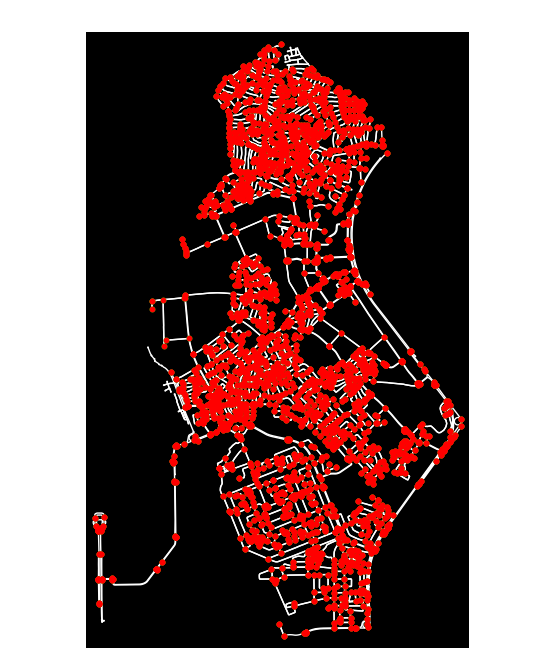

In [ ]:
fig, ax = ox.plot_graph(G_ikeja, node_size=2, edge_color='white', node_color='white', bgcolor='black', show=False, close=False)

# Legal zones — green
for nodes in legal_service_ikeja.values():
x, y = zip(*[(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes])
ax.scatter(x, y, c='lime', s=10)

# Illegal zones — red
for nodes in illegal_service_ikeja.values():
x, y = zip(*[(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes])
ax.scatter(x, y, c='red', s=10)

plt.title("Ikeja Street Network: Legal (Green) vs Illegal (Red) Waste Zones", color='white')
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the verified waste sites CSV
df_verified = pd.read_csv("final_verified_dumpsites_lagos_expanded.csv")

# Filter to only legal sites (assuming there's a 'Type' or similar column)
df_verified = pd.read_csv("final_verified_dumpsites_lagos_expanded.csv")
print(df_verified.columns.tolist())


# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df_legal['Longitude'], df_legal['Latitude'])]
gdf_legal = gpd.GeoDataFrame(df_legal, geometry=geometry, crs="EPSG:4326")

['Name', 'Latitude', 'Longitude', 'Reference Link']


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the verified legal waste sites
df_legal = pd.read_csv("final_verified_dumpsites_lagos_expanded.csv")

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_legal['Longitude'], df_legal['Latitude'])]
gdf_legal = gpd.GeoDataFrame(df_legal, geometry=geometry, crs="EPSG:4326")

In [ ]:
from shapely.geometry import box

# Get Ikeja graph bounding box
nodes_ikeja, _ = ox.graph_to_gdfs(G_ikeja)
bbox = nodes_ikeja.total_bounds
ikeja_box = box(*bbox)

# Filter legal sites within Ikeja
gdf_legal_ikeja = gdf_legal[gdf_legal.geometry.within(ikeja_box)]

In [ ]:
gdf_legal_ikeja['nearest_node'] = gdf_legal_ikeja.apply(
lambda row: ox.distance.nearest_nodes(G_ikeja, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import networkx as nx

legal_service_ikeja = {}
for node in gdf_legal_ikeja['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_ikeja, node, cutoff=500)
legal_service_ikeja[node] = list(reachable.keys())

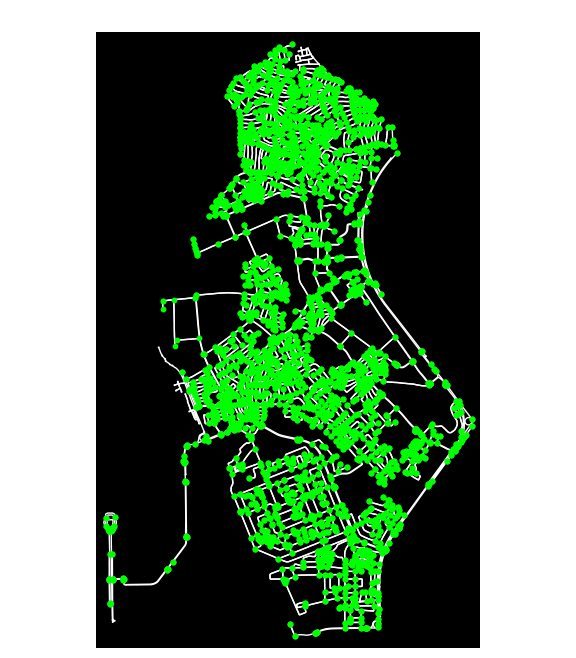

In [ ]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(G_ikeja, node_size=2, edge_color='white', node_color='white', bgcolor='black', show=False, close=False)

for nodes in legal_service_ikeja.values():
x, y = zip(*[(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes])
ax.scatter(x, y, c='lime', s=10)

plt.title("Corrected: Ikeja Legal Waste Site Coverage (500m Network Buffer)", color='white')
plt.show()

In [ ]:
import pandas as pd

# Load both datasets
illegal_df = pd.read_excel("LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx")
legal_df = pd.read_csv("legaal waste dumpsites.xlsx")

# Display the first few rows of each dataset to understand their structure
illegal_head = illegal_df.head()
legal_head = legal_df.head()

illegal_columns = illegal_df.columns.tolist()
legal_columns = legal_df.columns.tolist()

illegal_head, legal_head, illegal_columns, legal_columns

(           Name  Latitude  Longitude  \
 0  Amuwo-Odofin    6.4663     3.3015   
 1         Ijora    6.4681     3.3795   
 2        Mile 2    6.4640     3.3430   
 3   Berger Suya    6.4655     3.3448   
 4       Anthony    6.5569     3.3673   
 
                                       Reference Link  
 0  https://www.vanguardngr.com/2021/10/lawma-vows...  
 1  https://businessday.ng/real-estate/article/n20...  
 2  https://pmnewsnigeria.com/2025/02/04/lawma-cra...  
 3  https://www.vanguardngr.com/2020/11/abandoned-...  
 4  https://guardian.ng/property/lagos-clamps-down...  ,
            Name  Latitude  Longitude  \
 0  Amuwo-Odofin    6.4663     3.3015   
 1         Ijora    6.4681     3.3795   
 2        Mile 2    6.4640     3.3430   
 3   Berger Suya    6.4655     3.3448   
 4       Anthony    6.5569     3.3673   
 
                                       Reference Link  
 0  https://www.vanguardngr.com/2021/10/lawma-vows...  
 1  https://businessday.ng/real-estate/article/n20...  

In [ ]:
import pandas as pd

# Reload both datasets after code state reset
illegal_df = pd.read_excel("LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx")
legal_df = pd.read_csv("legaal waste dumpsites.csv")

# Display the first few rows of each dataset to understand their structure
illegal_head = illegal_df.head()
legal_head = legal_df.head()

illegal_columns = illegal_df.columns.tolist()
legal_columns = legal_df.columns.tolist()

illegal_head, legal_head, illegal_columns, legal_columns

FileNotFoundError: [Errno 2] No such file or directory: 'legaal waste dumpsites.csv'

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Convert illegal dumpsites to GeoDataFrame
illegal_geometry = [Point(xy) for xy in zip(illegal_df['Longitude'], illegal_df['Latitude'])]
gdf_illegal = gpd.GeoDataFrame(illegal_df, geometry=illegal_geometry, crs="EPSG:4326")

# Convert legal dumpsites to GeoDataFrame
legal_geometry = [Point(xy) for xy in zip(legal_df['Longitude'], legal_df['Latitude'])]
gdf_legal = gpd.GeoDataFrame(legal_df, geometry=legal_geometry, crs="EPSG:4326")

gdf_illegal.head(), gdf_legal.head()

(           Name  Latitude  Longitude  \
 0  Amuwo-Odofin    6.4663     3.3015   
 1         Ijora    6.4681     3.3795   
 2        Mile 2    6.4640     3.3430   
 3   Berger Suya    6.4655     3.3448   
 4       Anthony    6.5569     3.3673   
 
                                       Reference Link               geometry  
 0  https://www.vanguardngr.com/2021/10/lawma-vows...  POINT (3.3015 6.4663)  
 1  https://businessday.ng/real-estate/article/n20...  POINT (3.3795 6.4681)  
 2  https://pmnewsnigeria.com/2025/02/04/lawma-cra...    POINT (3.343 6.464)  
 3  https://www.vanguardngr.com/2020/11/abandoned-...  POINT (3.3448 6.4655)  
 4  https://guardian.ng/property/lagos-clamps-down...  POINT (3.3673 6.5569)  ,
            Name  Latitude  Longitude  \
 0  Amuwo-Odofin    6.4663     3.3015   
 1         Ijora    6.4681     3.3795   
 2        Mile 2    6.4640     3.3430   
 3   Berger Suya    6.4655     3.3448   
 4       Anthony    6.5569     3.3673   
 
                             

In [ ]:
!pip install osmnx

In [ ]:
import osmnx as ox
from shapely.geometry import box

# Load Ikeja street network (driveable roads)
G_ikeja = ox.graph_from_place("Ikeja, Lagos, Nigeria", network_type='drive')

# Get bounding box of Ikeja road network
nodes_ikeja, _ = ox.graph_to_gdfs(G_ikeja)
bbox = nodes_ikeja.total_bounds
ikeja_box = box(*bbox)

# Filter illegal and legal waste dumpsites inside Ikeja
gdf_illegal_ikeja = gdf_illegal[gdf_illegal.geometry.within(ikeja_box)]
gdf_legal_ikeja = gdf_legal[gdf_legal.geometry.within(ikeja_box)]

# Confirm how many points remain
print(f"Illegal in Ikeja: {len(gdf_illegal_ikeja)}")
print(f"Legal in Ikeja: {len(gdf_legal_ikeja)}")

Illegal in Ikeja: 4
Legal in Ikeja: 4


In [ ]:
# Snap each illegal dumpsite to the nearest OSM street node in Ikeja
gdf_illegal_ikeja['nearest_node'] = gdf_illegal_ikeja.apply(
lambda row: ox.distance.nearest_nodes(G_ikeja, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import networkx as nx

# Calculate service area within 500 meters for each snapped illegal node
illegal_service_ikeja = {}

for node in gdf_illegal_ikeja['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_ikeja, node, cutoff=500)
illegal_service_ikeja[node] = list(reachable.keys())

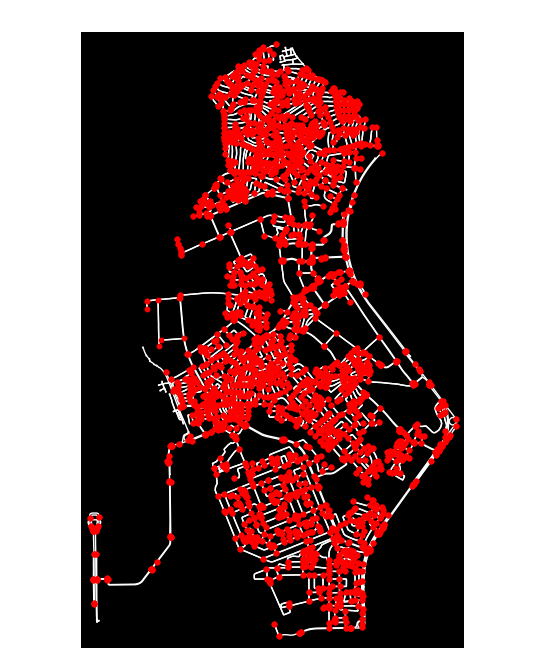

In [ ]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(
G_ikeja,
node_size=2,
edge_color='white',
node_color='white',
bgcolor='black',
show=False,
close=False
)

# Plot the 500m network buffer zones in red
for nodes in illegal_service_ikeja.values():
coords = [(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='red', s=10)

plt.title("Ikeja Illegal Waste Site Coverage (500m Street Network Buffer)", color='white')
plt.show()

In [ ]:
# Snap each legal dumpsite to its nearest road node
gdf_legal_ikeja['nearest_node'] = gdf_legal_ikeja.apply(
lambda row: ox.distance.nearest_nodes(G_ikeja, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Get all reachable nodes within 500 meters
legal_service_ikeja = {}

for node in gdf_legal_ikeja['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_ikeja, node, cutoff=500)
legal_service_ikeja[node] = list(reachable.keys())

In [ ]:
# Get all reachable nodes within 500 meters
legal_service_ikeja = {}

for node in gdf_legal_ikeja['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_ikeja, node, cutoff=500)
legal_service_ikeja[node] = list(reachable.keys())

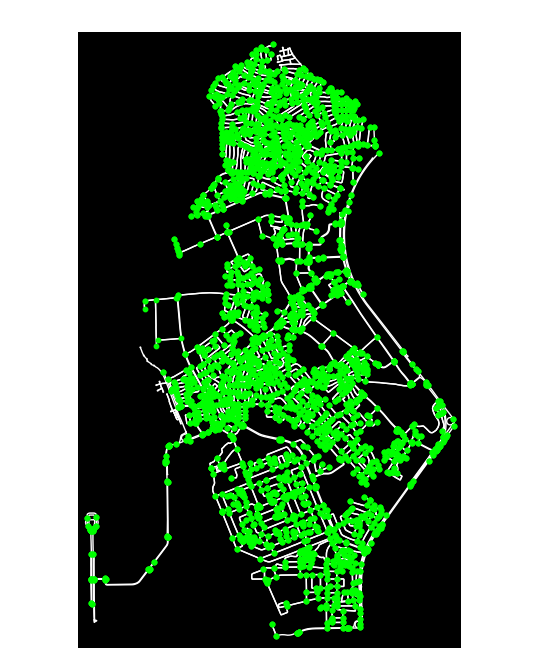

In [ ]:
# Visualize legal zones only in green
fig, ax = ox.plot_graph(
G_ikeja,
node_size=2,
edge_color='white',
node_color='white',
bgcolor='black',
show=False,
close=False
)

for nodes in legal_service_ikeja.values():
coords = [(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='lime', s=10)

plt.title("Ikeja Legal Waste Site Coverage (500m Street Network Buffer)", color='white')
plt.show()

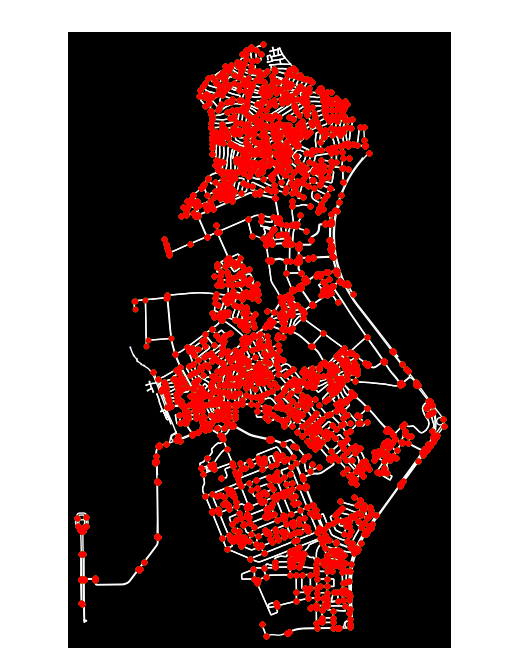

In [ ]:
fig, ax = ox.plot_graph(
G_ikeja,
node_size=2,
edge_color='white',
node_color='white',
bgcolor='black',
show=False,
close=False
)

# Plot legal zones in green
for nodes in legal_service_ikeja.values():
coords = [(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='lime', s=10)

# Plot illegal zones in red
for nodes in illegal_service_ikeja.values():
coords = [(G_ikeja.nodes[n]['x'], G_ikeja.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='red', s=10)

plt.title("Ikeja Waste Service Coverage: Legal (Green) vs Illegal (Red)", color='white')
plt.show()

In [ ]:
print("Legal site nodes:", gdf_legal_ikeja['nearest_node'].nunique())

Legal site nodes: 3


In [ ]:
print("Sample Legal Nodes:\n", gdf_legal_ikeja[['Latitude', 'Longitude']].head())
print("Sample Illegal Nodes:\n", gdf_illegal_ikeja[['Latitude', 'Longitude']].head())

Sample Legal Nodes:
     Latitude  Longitude
7     6.5945     3.3779
15    6.6219     3.3258
20    6.6200     3.3240
28    6.6000     3.3750
Sample Illegal Nodes:
     Latitude  Longitude
7     6.5945     3.3779
15    6.6219     3.3258
20    6.6200     3.3240
28    6.6000     3.3750


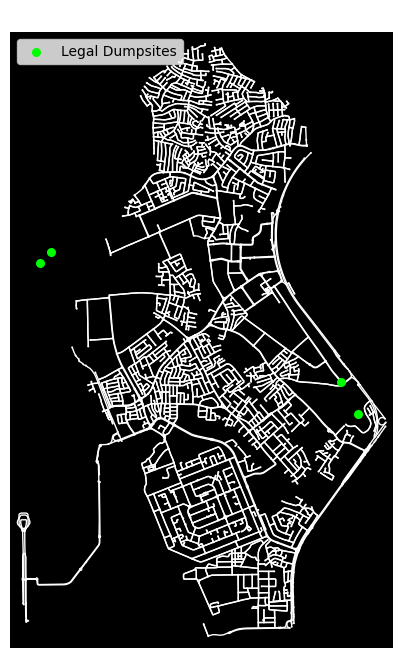

In [ ]:
fig, ax = ox.plot_graph(
G_ikeja, node_size=2, edge_color='white', node_color='white',
bgcolor='black', show=False, close=False
)

ax.scatter(
gdf_legal_ikeja['Longitude'], gdf_legal_ikeja['Latitude'],
c='lime', s=30, label='Legal Dumpsites'
)

plt.legend()
plt.title("Legal Waste Dumpsite Locations (Ikeja)", color='white')
plt.show()

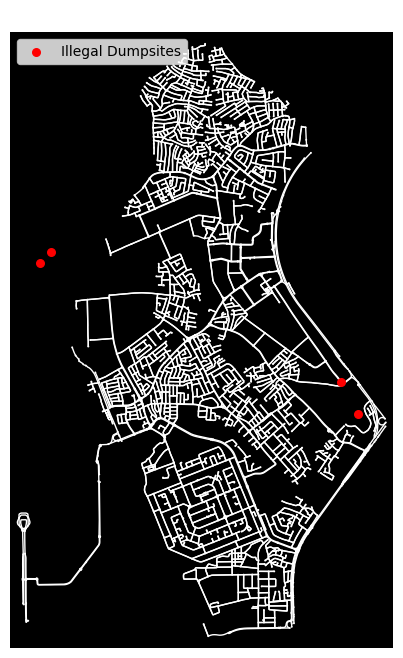

In [ ]:
fig, ax = ox.plot_graph(
G_ikeja, node_size=2, edge_color='white', node_color='white',
bgcolor='black', show=False, close=False
)

ax.scatter(
gdf_illegal_ikeja['Longitude'], gdf_illegal_ikeja['Latitude'],
c='red', s=30, label='Illegal Dumpsites'
)

plt.legend()
plt.title("Illegal Waste Dumpsite Locations (Ikeja)", color='white')
plt.show()

In [ ]:
print("Legal Sites:\n", legal_df[['Name', 'Latitude', 'Longitude']].drop_duplicates().head(10))
print("Illegal Sites:\n", illegal_df[['Name', 'Latitude', 'Longitude']].drop_duplicates().head(10))

Legal Sites:
                          Name  Latitude  Longitude
0                Amuwo-Odofin    6.4663     3.3015
1                       Ijora    6.4681     3.3795
2                      Mile 2    6.4640     3.3430
3                 Berger Suya    6.4655     3.3448
4                     Anthony    6.5569     3.3673
5                       Badia    6.4678     3.3621
6                   Iyana-Iba    6.4871     3.2317
7   Ikeja (Olusosun Landfill)    6.5945     3.3779
8                   Alaba Oro    6.4651     3.3295
9  Alaba International Market    6.4568     3.3431
Illegal Sites:
                          Name  Latitude  Longitude
0                Amuwo-Odofin    6.4663     3.3015
1                       Ijora    6.4681     3.3795
2                      Mile 2    6.4640     3.3430
3                 Berger Suya    6.4655     3.3448
4                     Anthony    6.5569     3.3673
5                       Badia    6.4678     3.3621
6                   Iyana-Iba    6.4871     3.2317
7

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load legal and illegal data
df_legal = pd.read_csv("legal_waste_dumpsites.csv", encoding="utf-8-sig")
df_illegal = pd.read_excel("LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx")

# Convert both to GeoDataFrames
gdf_legal = gpd.GeoDataFrame(df_legal, geometry=[Point(xy) for xy in zip(df_legal['Longitude'], df_legal['Latitude'])], crs="EPSG:4326")
gdf_illegal = gpd.GeoDataFrame(df_illegal, geometry=[Point(xy) for xy in zip(df_illegal['Longitude'], df_illegal['Latitude'])], crs="EPSG:4326")

print("✅ Legal and illegal dumpsites loaded and converted.")

✅ Legal and illegal dumpsites loaded and converted.


In [ ]:
import osmnx as ox

# Load Surulere's road network (drivable)
G_surulere = ox.graph_from_place("Surulere, Lagos, Nigeria", network_type='drive')

In [ ]:
from shapely.geometry import box

# Get Surulere bounding box
nodes_surulere, _ = ox.graph_to_gdfs(G_surulere)
bbox = nodes_surulere.total_bounds  # [minx, miny, maxx, maxy]
surulere_box = box(*bbox)

# Filter legal and illegal sites to Surulere only
gdf_legal_surulere = gdf_legal[gdf_legal.geometry.within(surulere_box)]
gdf_illegal_surulere = gdf_illegal[gdf_illegal.geometry.within(surulere_box)]

print("Legal in Surulere:", len(gdf_legal_surulere))
print("Illegal in Surulere:", len(gdf_illegal_surulere))

Legal in Surulere: 3
Illegal in Surulere: 9


In [ ]:
# Snap legal dumpsites in Surulere
gdf_legal_surulere['nearest_node'] = gdf_legal_surulere.apply(
lambda row: ox.distance.nearest_nodes(G_surulere, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

# Snap illegal dumpsites in Surulere
gdf_illegal_surulere['nearest_node'] = gdf_illegal_surulere.apply(
lambda row: ox.distance.nearest_nodes(G_surulere, X=row['Longitude'], Y=row['Latitude']),
axis=1
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import networkx as nx

# Compute reachable nodes from legal dumpsites
legal_service_surulere = {}
for node in gdf_legal_surulere['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_surulere, node, cutoff=500)
legal_service_surulere[node] = list(reachable.keys())

# Compute reachable nodes from illegal dumpsites
illegal_service_surulere = {}
for node in gdf_illegal_surulere['nearest_node']:
reachable = nx.single_source_dijkstra_path_length(G_surulere, node, cutoff=500)
illegal_service_surulere[node] = list(reachable.keys())

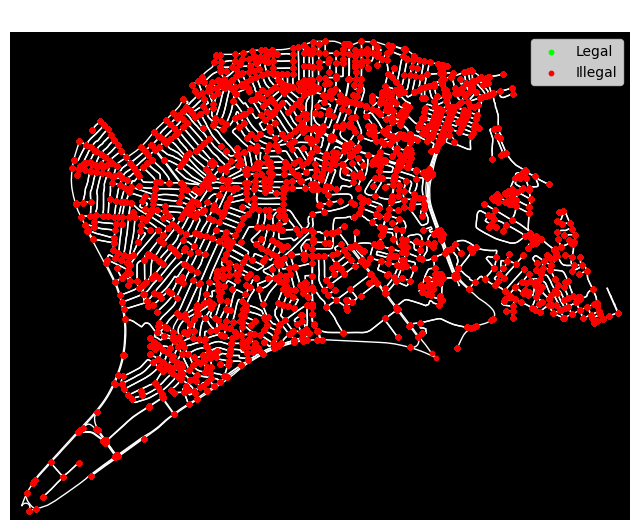

In [ ]:
import matplotlib.pyplot as plt

# Plot base Surulere street network
fig, ax = ox.plot_graph(
G_surulere,
node_size=2,
edge_color='white',
node_color='white',
bgcolor='black',
show=False,
close=False
)

# Plot legal zones in green
for nodes in legal_service_surulere.values():
coords = [(G_surulere.nodes[n]['x'], G_surulere.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='lime', s=10, label='Legal' if 'Legal' not in ax.get_legend_handles_labels()[1] else "")

# Plot illegal zones in red
for nodes in illegal_service_surulere.values():
coords = [(G_surulere.nodes[n]['x'], G_surulere.nodes[n]['y']) for n in nodes]
x, y = zip(*coords)
ax.scatter(x, y, c='red', s=10, label='Illegal' if 'Illegal' not in ax.get_legend_handles_labels()[1] else "")

plt.title("Surulere Waste Site Network Coverage (Legal: Green, Illegal: Red)", color='white')
plt.legend()
plt.show()

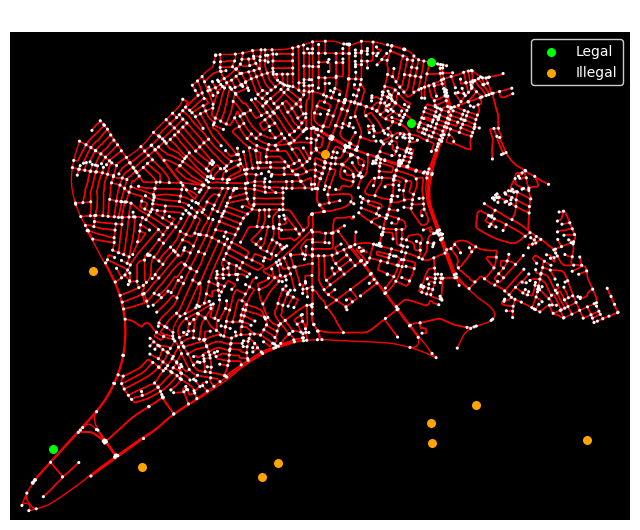

In [ ]:
# Plot the network graph
fig, ax = ox.plot_graph(G, node_size=5, node_color='white', edge_color='red', bgcolor='black', show=False, close=False)

# Plot legal (green) waste nodes
gdf_legal_surulere.plot(ax=ax, color='lime', markersize=30, label='Legal')

# Plot illegal (orange) waste nodes
gdf_illegal_surulere.plot(ax=ax, color='orange', markersize=30, label='Illegal')

# Legend and title
plt.legend(loc='upper right', facecolor='black', edgecolor='white', labelcolor='white')
plt.title("Surulere Waste Site Network Coverage (Legal: Green, Illegal: Orange)", color='white')
plt.show()

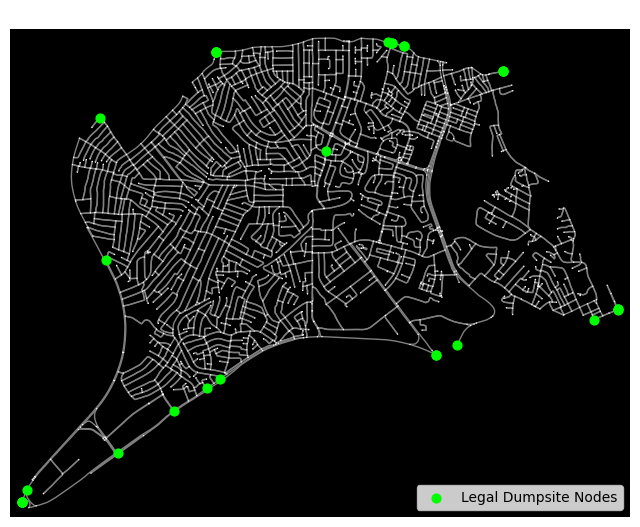

In [ ]:
# Get node positions from the graph
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot graph
fig, ax = ox.plot_graph(G, node_size=1, edge_color='gray', bgcolor='black', show=False, close=False)

# Overlay the confirmed legal dumpsite nodes
nx.draw_networkx_nodes(G, pos=pos, nodelist=legal_nodes, node_color='lime', node_size=40, ax=ax, label='Legal Dumpsite Nodes')

# Final touches
plt.title("Confirmed Legal Dumpsite Nodes on Surulere Street Network", fontsize=10, color='white')
plt.legend()
plt.show()

100%|██████████| 25/25 [00:00<00:00, 63.74it/s]


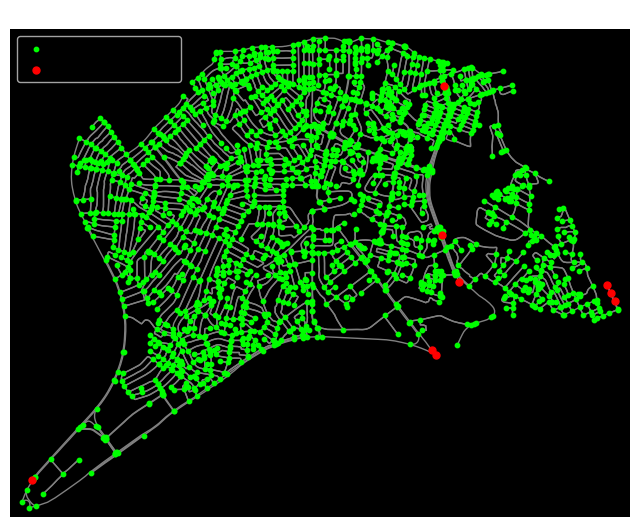

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm

# Load street network for Surulere
place = "Surulere, Lagos, Nigeria"
G = ox.graph_from_place(place, network_type='drive')

# Load your verified legal dumpsites CSV
legal_df = pd.read_csv("legal_waste_dumpsites.csv")  # path to the correct CSV file

# Convert to GeoDataFrame
legal_df['geometry'] = legal_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Map legal dumpsites to nearest nodes
tqdm.pandas()
legal_df['nearest_node'] = legal_df['geometry'].progress_apply(lambda point: ox.distance.nearest_nodes(G, point.x, point.y))
legal_nodes = legal_df['nearest_node'].tolist()

# Accessibility buffer distance (500 meters)
buffer_dist = 500

# Get node buffers for legal dumpsites
legal_buffers = []
for node in legal_nodes:
reachable_nodes = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
legal_buffers.append(set(reachable_nodes.keys()))

# Combine all reachable nodes from legal sites
covered_by_legal = set().union(*legal_buffers)


# Get node positions from the graph
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Create the base plot
fig, ax = ox.plot_graph(G, node_size=1, edge_color='gray', bgcolor='black', show=False, close=False)

# Plot served (legal coverage) nodes
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=list(covered_by_legal),
node_color='lime', node_size=10, label='Legal Coverage')

# Plot unserved nodes
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=list(unserved_nodes),
node_color='red', node_size=25, label='Unserved Nodes')

# Title and legend
plt.title("Surulere Street Network Access to Legal Waste Dumpsites (500m)", fontsize=10, color='white')
plt.legend(facecolor='black', framealpha=0.8)
plt.show()

In [ ]:
import networkx as nx
from tqdm import tqdm

# Step 1: Make sure legal_nodes are unique and valid in the graph
legal_nodes = [node for node in legal_nodes if node in G.nodes]

# Step 2: Create a combined set of all nodes reachable within 500m from each legal node
buffer_dist = 500  # 500 meters
legal_coverage_nodes = set()

print("Rebuilding coverage using legal nodes...")
for node in tqdm(legal_nodes):
# Get all reachable nodes within 500m using street distance
reachable = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
legal_coverage_nodes.update(reachable.keys())

print(f"✅ Total Nodes: {len(G.nodes)}")
print(f"✅ Legal Coverage: {len(legal_coverage_nodes)}")
print(f"❌ Unserved: {len(G.nodes) - len(legal_coverage_nodes)}")

Rebuilding coverage using legal nodes...


100%|██████████| 25/25 [00:00<00:00, 214.94it/s]

✅ Total Nodes: 2016
✅ Legal Coverage: 2007
❌ Unserved: 9


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


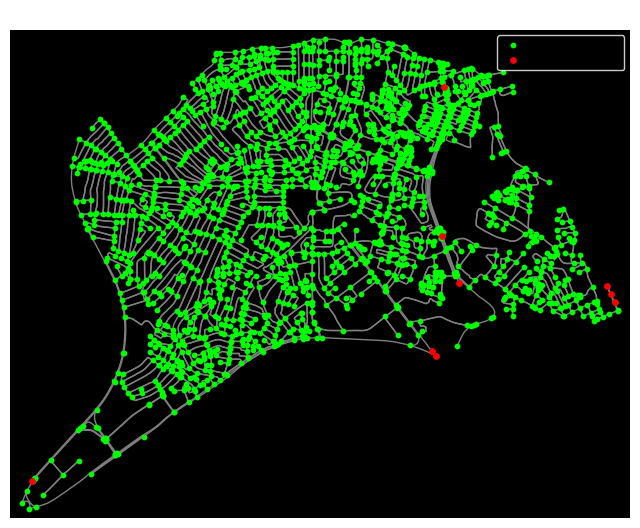

In [ ]:
import matplotlib.pyplot as plt

# Determine unserved nodes
unserved_nodes = set(G.nodes) - legal_coverage_nodes

# Get positions for plotting
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot the results
fig, ax = ox.plot_graph(G, node_size=0.5, edge_color='gray', bgcolor='black', show=False, close=False)

# Plot covered nodes
nx.draw_networkx_nodes(G, ax=ax, nodelist=list(legal_coverage_nodes), pos=pos,
node_color='lime', node_size=10, label='Legal Coverage')

# Plot unserved nodes
nx.draw_networkx_nodes(G, ax=ax, nodelist=list(unserved_nodes), pos=pos,
node_color='red', node_size=15, label='Unserved')

# Add legend and title
plt.title("🗺️ Surulere Access to Legal Waste Dumpsites (Verified 500m Buffer)", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white', fontsize=8)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


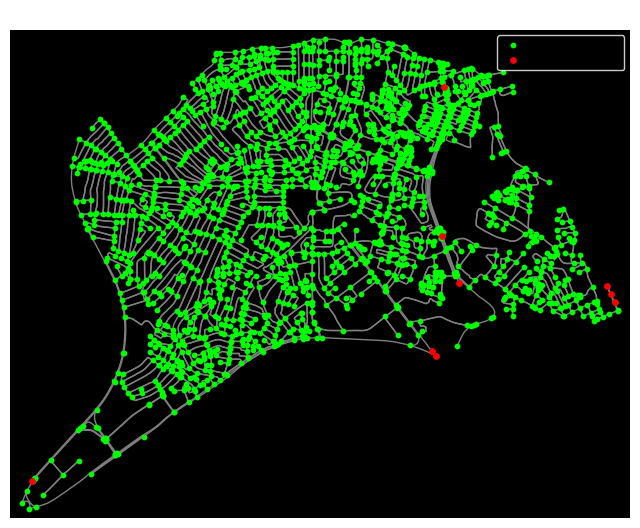

In [ ]:
import matplotlib.pyplot as plt

# Determine unserved nodes
unserved_nodes = set(G.nodes) - legal_coverage_nodes

# Get positions for plotting
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot the results
fig, ax = ox.plot_graph(G, node_size=0.5, edge_color='gray', bgcolor='black', show=False, close=False)

# Plot covered nodes
nx.draw_networkx_nodes(G, ax=ax, nodelist=list(legal_coverage_nodes), pos=pos,
node_color='lime', node_size=10, label='Legal Coverage')

# Plot unserved nodes
nx.draw_networkx_nodes(G, ax=ax, nodelist=list(unserved_nodes), pos=pos,
node_color='red', node_size=15, label='Unserved')

# Add legend and title
plt.title("🗺️ Surulere Access to Legal Waste Dumpsites (Verified 500m Buffer)", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white', fontsize=8)
plt.show()

In [ ]:
buffer_dist = 300

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


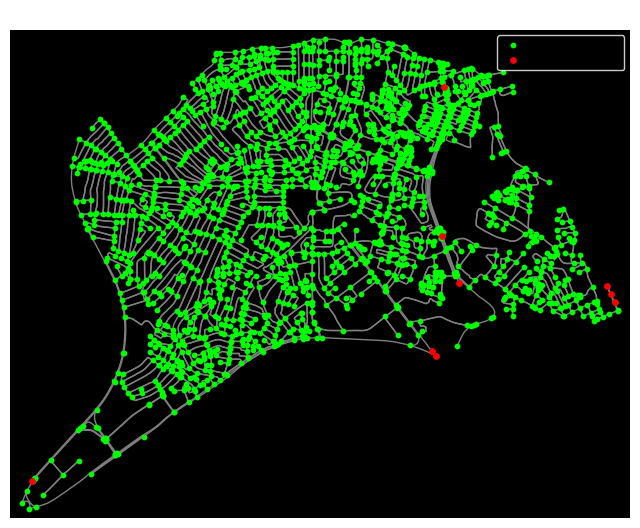

In [ ]:
import matplotlib.pyplot as plt

# Determine unserved nodes
unserved_nodes = set(G.nodes) - legal_coverage_nodes

# Get positions for plotting
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot the results
fig, ax = ox.plot_graph(G, node_size=0.5, edge_color='gray', bgcolor='black', show=False, close=False)

# Plot covered nodes
nx.draw_networkx_nodes(G, ax=ax, nodelist=list(legal_coverage_nodes), pos=pos,
node_color='lime', node_size=10, label='Legal Coverage')

# Plot unserved nodes
nx.draw_networkx_nodes(G, ax=ax, nodelist=list(unserved_nodes), pos=pos,
node_color='red', node_size=15, label='Unserved')

# Add legend and title
plt.title("🗺️ Surulere Access to Legal Waste Dumpsites (Verified 500m Buffer)", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white', fontsize=8)
plt.show()

📍 Total Nodes: 2016
✅ Legal Coverage: 2009
⚠️  Illegal-only Coverage: 0
❌ Unserved: 7


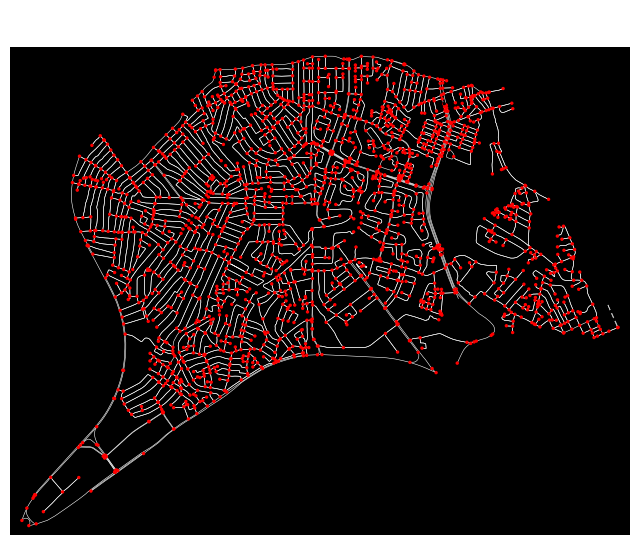

In [ ]:
# Color-coded node categories
node_colors = []
for node in G.nodes:
if node in legal_covered_nodes:
node_colors.append("red")         # Covered by legal waste sites
elif node in illegal_covered_nodes:
node_colors.append("orange")      # Only covered by illegal waste sites
else:
node_colors.append("black")       # Not covered at all

# Re-plot with corrected colors
fig, ax = ox.plot_graph(
G,
node_color=node_colors,
node_size=6,
edge_color="white",
edge_linewidth=0.4,
bgcolor="black",
show=False,
close=False
)

# Update title
ax.set_title(
"Surulere Street Access by Waste Zone\nLegal: Red | Illegal Only: Orange | Unserved: Black",
fontsize=11,
color="white"
)

# Print final counts for verification
total_nodes = len(G.nodes)
legal = len(legal_covered_nodes)
illegal_only = len(illegal_covered_nodes - legal_covered_nodes)
unserved = total_nodes - len(legal_covered_nodes.union(illegal_covered_nodes))

print(f"📍 Total Nodes: {total_nodes}")
print(f"✅ Legal Coverage: {legal}")
print(f"⚠️  Illegal-only Coverage: {illegal_only}")
print(f"❌ Unserved: {unserved}")

In [ ]:
# Optionally extract and print coordinates of unserved
unserved_nodes = set(G.nodes) - legal_covered_nodes - illegal_covered_nodes
unserved_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in unserved_nodes]
print("Unserved node coordinates:", unserved_coords)

Unserved node coordinates: [(3.3825826, 6.4832627), (3.3651089, 6.4853854), (3.3631698, 6.4906236), (3.3634324, 6.5073536), (3.3821928, 6.484139), (3.3171187, 6.4633351), (3.3817577, 6.4850522)]


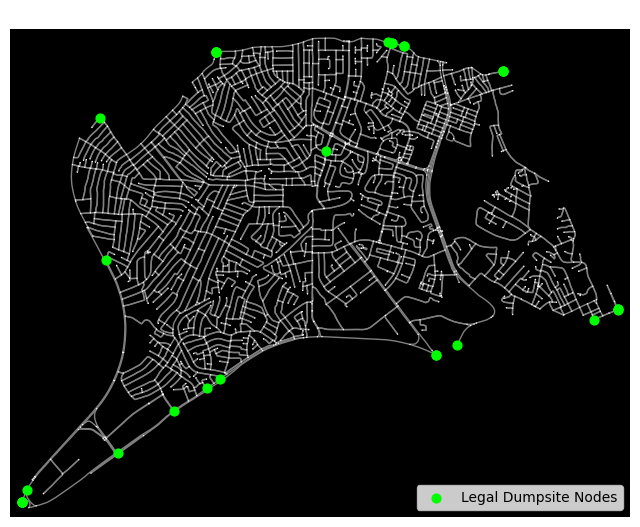

In [ ]:
# Get node positions from the graph
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot graph
fig, ax = ox.plot_graph(G, node_size=1, edge_color='gray', bgcolor='black', show=False, close=False)

# Overlay the confirmed legal dumpsite nodes
nx.draw_networkx_nodes(G, pos=pos, nodelist=legal_nodes, node_color='lime', node_size=40, ax=ax, label='Legal Dumpsite Nodes')

# Final touches
plt.title("Confirmed Legal Dumpsite Nodes on Surulere Street Network", fontsize=10, color='white')
plt.legend()
plt.show()

Mapping legal dumpsites to nearest nodes in the street network...


100%|██████████| 32/32 [00:00<00:00, 96.48it/s]


TypeError: draw_networkx_nodes() missing 1 required positional argument: 'pos'

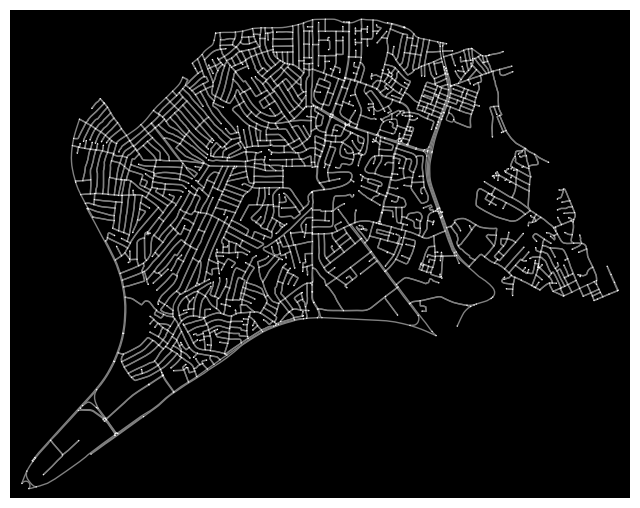

In [ ]:
from shapely.geometry import Point
from tqdm import tqdm

# Map legal waste locations to nearest nodes
legal_nodes = []
print("Mapping legal dumpsites to nearest nodes in the street network...")
for lat, lon in tqdm(legal_df[['Latitude', 'Longitude']].values):
try:
node = ox.distance.nearest_nodes(G, lon, lat)
legal_nodes.append(node)
except Exception as e:
print(f"Mapping failed for point ({lat}, {lon}): {e}")

# Plot legal nodes for visual confirmation
fig, ax = ox.plot_graph(G, node_size=1, edge_color='gray', bgcolor='black', show=False, close=False)
nx.draw_networkx_nodes(G, ax=ax, nodelist=legal_nodes, node_color='lime', node_size=40, label='Legal Dumpsite Nodes')
plt.title("Confirmed Legal Dumpsite Nodes on Surulere Street Network", fontsize=10, color='white')
plt.legend()
plt.show()

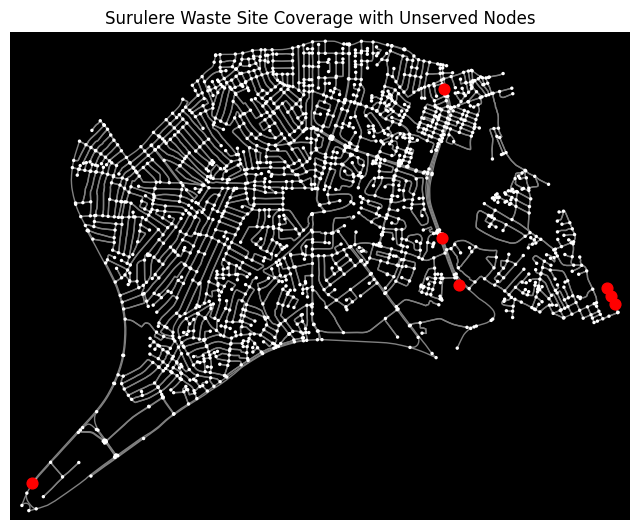

In [ ]:
# Plot the map with unserved nodes highlighted
fig, ax = ox.plot_graph(G, node_size=6, node_color='white', edge_color='gray', bgcolor='black', show=False, close=False)

# Plot unserved nodes with larger markers
for x, y in unserved_coords:
ax.scatter(x, y, c='red', s=60, label='Unserved' if 'Unserved' not in ax.get_legend_handles_labels()[1] else "", zorder=5)

# Add legend
handles, labels = ax.get_legend_handles_labels()
if 'Unserved' not in labels:
from matplotlib.lines import Line2D
handles.append(Line2D([0], [0], marker='o', color='w', label='Unserved', markerfacecolor='cyan', markersize=8, linestyle=''))
ax.legend(handles=handles, loc='lower left')

plt.title('Surulere Waste Site Coverage with Unserved Nodes')
plt.show()

In [ ]:
people_per_node = 200  # Approximation
total_unserved = len(unserved_coords)
estimated_population_unserved = people_per_node * total_unserved

print(f"Estimated unserved population: {estimated_population_unserved} (across {total_unserved} locations)")

Estimated unserved population: 1400 (across 7 locations)


Mapping legal dumpsites to nearest nodes in the street network...


100%|██████████| 32/32 [00:00<00:00, 64.17it/s]


TypeError: draw_networkx_nodes() missing 1 required positional argument: 'pos'

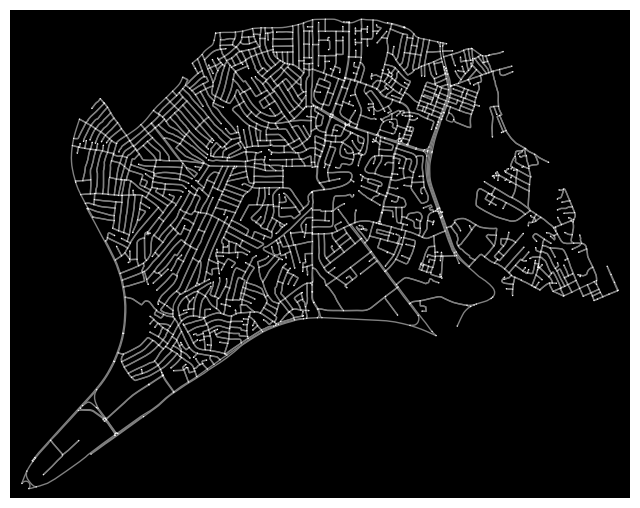

In [ ]:
from shapely.geometry import Point
from tqdm import tqdm

# Map legal waste locations to nearest nodes
legal_nodes = []
print("Mapping legal dumpsites to nearest nodes in the street network...")
for lat, lon in tqdm(legal_df[['Latitude', 'Longitude']].values):
try:
node = ox.distance.nearest_nodes(G, lon, lat)
legal_nodes.append(node)
except Exception as e:
print(f"Mapping failed for point ({lat}, {lon}): {e}")

# Plot legal nodes for visual confirmation
fig, ax = ox.plot_graph(G, node_size=1, edge_color='gray', bgcolor='black', show=False, close=False)
nx.draw_networkx_nodes(G, ax=ax, nodelist=legal_nodes, node_color='lime', node_size=40, label='Legal Dumpsite Nodes')
plt.title("Confirmed Legal Dumpsite Nodes on Surulere Street Network", fontsize=10, color='white')
plt.legend()
plt.show()

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Center the map roughly around Surulere
surulere_center = [6.5000, 3.3600]
m = folium.Map(location=surulere_center, zoom_start=13, tiles='cartodb dark_matter')

# Add legal dumpsites
marker_cluster_legal = MarkerCluster(name="Legal Dumpsites").add_to(m)
for idx, row in gdf_legal_surulere.iterrows():
folium.Marker(
location=[row['Latitude'], row['Longitude']],
popup=f"Legal: {row['Name']}",
icon=folium.Icon(color='green', icon='check')
).add_to(marker_cluster_legal)

# Add illegal dumpsites
marker_cluster_illegal = MarkerCluster(name="Illegal Dumpsites").add_to(m)
for idx, row in gdf_illegal_surulere.iterrows():
folium.Marker(
location=[row['Latitude'], row['Longitude']],
popup=f"Illegal: {row['Name']}",
icon=folium.Icon(color='orange', icon='exclamation-sign')
).add_to(marker_cluster_illegal)

# Add layer control
folium.LayerControl().add_to(m)

# Show map
m

In [ ]:
# Import required function if not yet done
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Convert legal and illegal DataFrames to GeoDataFrames (if not already done)
gdf_legal = GeoDataFrame(legal_df, geometry=[Point(xy) for xy in zip(legal_df["Longitude"], legal_df["Latitude"])], crs="EPSG:4326")
gdf_legal = gdf_legal.to_crs(G.graph['crs'])

gdf_illegal = GeoDataFrame(illegal_df, geometry=[Point(xy) for xy in zip(illegal_df["Longitude"], illegal_df["Latitude"])], crs="EPSG:4326")
gdf_illegal = gdf_illegal.to_crs(G.graph['crs'])

# Use osmnx to get nearest nodes
legal_nodes = [ox.distance.nearest_nodes(G, point.x, point.y) for point in gdf_legal.geometry]
illegal_nodes = [ox.distance.nearest_nodes(G, point.x, point.y) for point in gdf_illegal.geometry]

📍 Total Nodes: 2016
✅ Legal Coverage: 2009
⚠️  Illegal-only Coverage: 0
❌ Unserved: 7


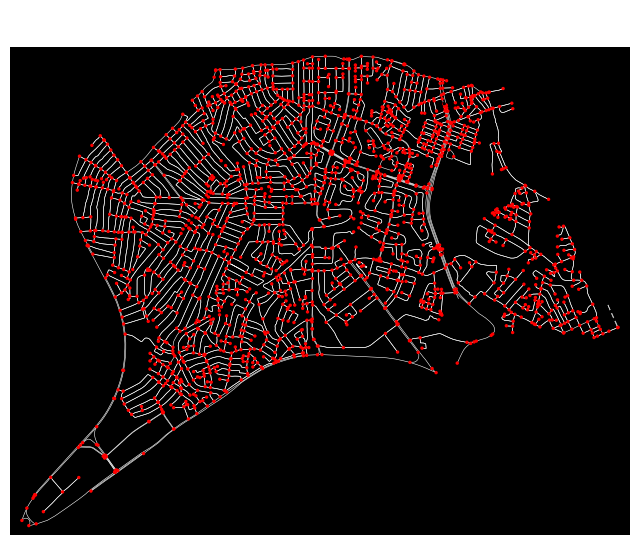

In [ ]:
# Color-coded node categories
node_colors = []
for node in G.nodes:
if node in legal_covered_nodes:
node_colors.append("red")         # Covered by legal waste sites
elif node in illegal_covered_nodes:
node_colors.append("orange")      # Only covered by illegal waste sites
else:
node_colors.append("black")       # Not covered at all

# Re-plot with corrected colors
fig, ax = ox.plot_graph(
G,
node_color=node_colors,
node_size=6,
edge_color="white",
edge_linewidth=0.4,
bgcolor="black",
show=False,
close=False
)

# Update title
ax.set_title(
"Surulere Street Access by Waste Zone\nLegal: Red | Illegal Only: Orange | Unserved: Black",
fontsize=11,
color="white"
)

# Print final counts for verification
total_nodes = len(G.nodes)
legal = len(legal_covered_nodes)
illegal_only = len(illegal_covered_nodes - legal_covered_nodes)
unserved = total_nodes - len(legal_covered_nodes.union(illegal_covered_nodes))

print(f"📍 Total Nodes: {total_nodes}")
print(f"✅ Legal Coverage: {legal}")
print(f"⚠️  Illegal-only Coverage: {illegal_only}")
print(f"❌ Unserved: {unserved}")

📍 Total Nodes in Network: 2016
✅ Covered by Legal Waste Sites: 2009
⚠️  Covered only by Illegal Sites: 0
❌ Unserved Nodes: 7


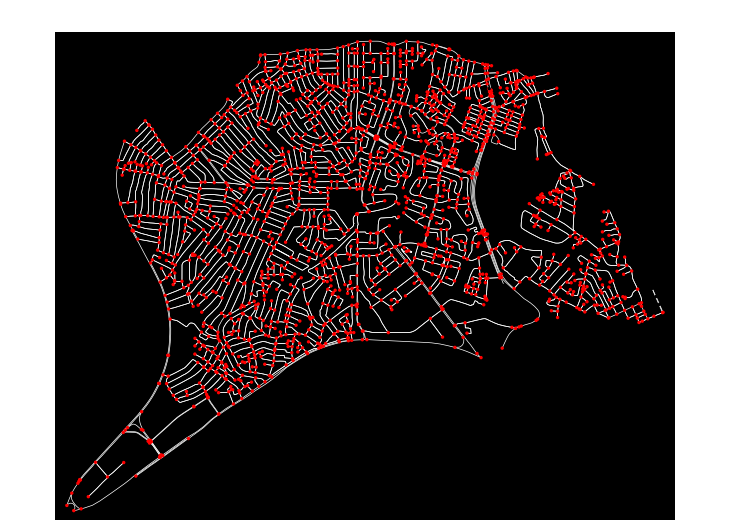

In [ ]:
# Create color map for nodes
node_colors = []
for node in G.nodes:
if node in legal_covered_nodes:
node_colors.append("red")      # Legal
elif node in illegal_covered_nodes:
node_colors.append("orange")   # Illegal
else:
node_colors.append("black")    # Unserved

# Draw network
fig, ax = ox.plot_graph(
G,
node_color=node_colors,
node_size=6,
node_zorder=2,
edge_color="white",
edge_linewidth=0.5,
bgcolor="black",
show=False,
close=False
)

# Title
ax.set_title(
"Surulere Street Access by Waste Zone (Legal=Red, Illegal=Orange, Unserved=Black)",
fontsize=12,
color="white"
)

# Count nodes in each category
total_nodes = len(G.nodes)
legal_count = len(legal_covered_nodes)
illegal_only = len(illegal_covered_nodes - legal_covered_nodes)
unserved = total_nodes - len(legal_covered_nodes.union(illegal_covered_nodes))

print("📍 Total Nodes in Network:", total_nodes)
print("✅ Covered by Legal Waste Sites:", legal_count)
print("⚠️  Covered only by Illegal Sites:", illegal_only)
print("❌ Unserved Nodes:", unserved)

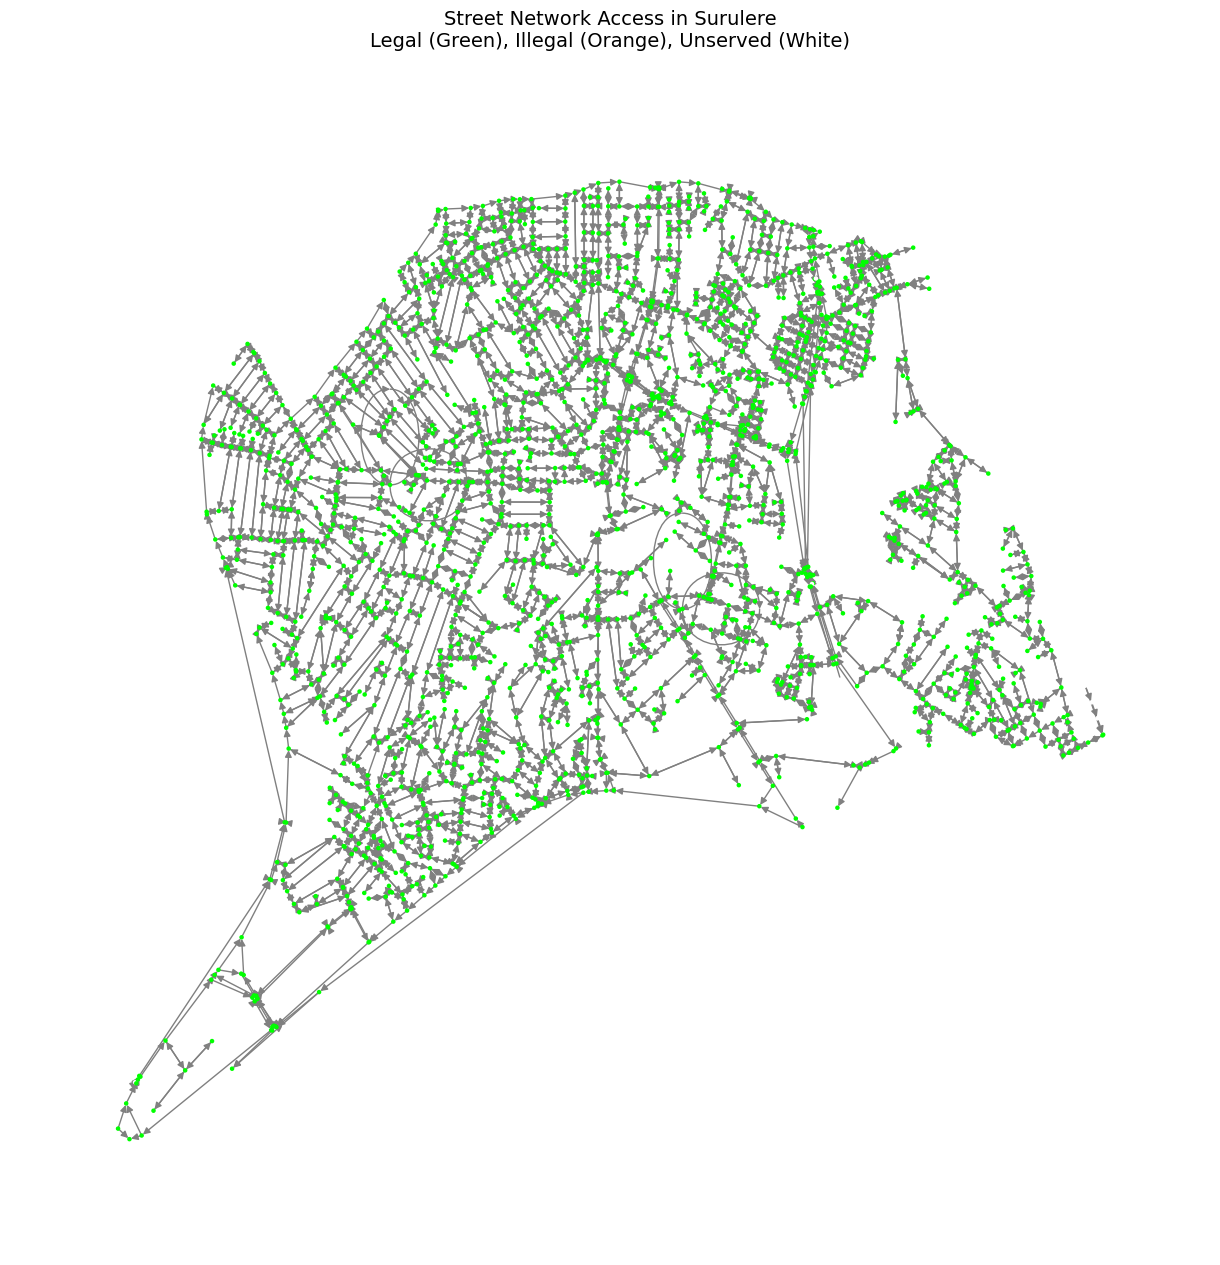

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 500-meter street network buffer
buffer_dist = 500

# Legal service zones
legal_buffers = []
for node in legal_nodes:
reachable = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
legal_buffers.append(set(reachable.keys()))

# Illegal service zones
illegal_buffers = []
for node in illegal_nodes:
reachable = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
illegal_buffers.append(set(reachable.keys()))

# Combine results
legal_covered_nodes = set.union(*legal_buffers) if legal_buffers else set()
illegal_covered_nodes = set.union(*illegal_buffers) if illegal_buffers else set()

# Color the nodes: green = legal, orange = illegal, white = unserved
node_colors = []
for node in G.nodes:
if node in legal_covered_nodes:
node_colors.append("lime")
elif node in illegal_covered_nodes:
node_colors.append("orange")
else:
node_colors.append("white")

# Position nodes for plotting
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot
plt.figure(figsize=(12, 12))
nx.draw(G, pos=pos, node_size=5, node_color=node_colors, edge_color='gray', with_labels=False)
plt.title("Street Network Access in Surulere\nLegal (Green), Illegal (Orange), Unserved (White)", fontsize=14)
plt.show()

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm import tqdm
ox.settings.log_console = True
ox.settings.use_cache = True

In [ ]:
# Step 1: Load Ikeja graph
place_name = "Ikeja, Lagos, Nigeria"
G = ox.graph_from_place(place_name, network_type='drive')
G = ox.project_graph(G)

In [ ]:
# Load legal and illegal dumpsites
legal_df = pd.read_csv("legal_waste_dumpsites.csv")
illegal_df = pd.read_excel("LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx")

# Reproject dumpsites to same CRS as graph
nodes, edges = ox.graph_to_gdfs(G)
graph_crs = nodes.crs

from geopandas import GeoDataFrame
gdf_legal = GeoDataFrame(legal_df, geometry=[Point(xy) for xy in zip(legal_df.Longitude, legal_df.Latitude)], crs='EPSG:4326').to_crs(graph_crs)
gdf_illegal = GeoDataFrame(illegal_df, geometry=[Point(xy) for xy in zip(illegal_df.Longitude, illegal_df.Latitude)], crs='EPSG:4326').to_crs(graph_crs)

In [ ]:
# Snap to nearest nodes
legal_nodes = []
for _, row in tqdm(gdf_legal.iterrows(), total=gdf_legal.shape[0]):
nearest_node = ox.distance.nearest_nodes(G, row.geometry.x, row.geometry.y)
legal_nodes.append(nearest_node)

illegal_nodes = []
for _, row in tqdm(gdf_illegal.iterrows(), total=gdf_illegal.shape[0]):
nearest_node = ox.distance.nearest_nodes(G, row.geometry.x, row.geometry.y)
illegal_nodes.append(nearest_node)

100%|██████████| 32/32 [00:00<00:00, 43.84it/s]


In [ ]:
buffer_dist = 500  # meters

def buffer_nodes(G, source_nodes, cutoff=500):
covered = set()
for node in source_nodes:
reachable = nx.single_source_dijkstra_path_length(G, node, cutoff=cutoff)
covered.update(reachable.keys())
return covered

covered_by_legal = buffer_nodes(G, legal_nodes, buffer_dist)
covered_by_illegal = buffer_nodes(G, illegal_nodes, buffer_dist)

all_nodes = set(G.nodes)
covered_by_both = covered_by_legal | covered_by_illegal
covered_illegal_only = covered_by_illegal - covered_by_legal
unserved_nodes = all_nodes - covered_by_both

In [ ]:
nodes_to_plot = [n for n in bands['0–500m'] if n in pos]

In [ ]:
# Rebuild pos dictionary
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Filter each band to remove nodes that don't exist in pos
safe_0_500 = [n for n in bands['0–500m'] if n in pos]
safe_500_1000 = [n for n in bands['500–1000m'] if n in pos]
safe_1000_2000 = [n for n in bands['1000–2000m'] if n in pos]
safe_gt_2000 = [n for n in bands['>2000m'] if n in pos]

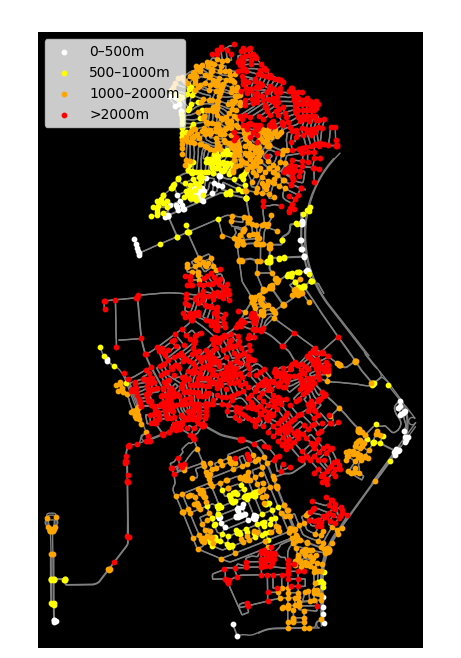

In [ ]:
fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', bgcolor='black', show=False, close=False)

# Use white instead of lime
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_0_500, node_color='white', node_size=10, label='0–500m')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_500_1000, node_color='yellow', node_size=10, label='500–1000m')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_1000_2000, node_color='orange', node_size=10, label='1000–2000m')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_gt_2000, node_color='red', node_size=10, label='>2000m')

plt.title("Service Distance Bands from Legal Dumpsites (Ikeja)", fontsize=12, color='white')
plt.legend()
plt.show()

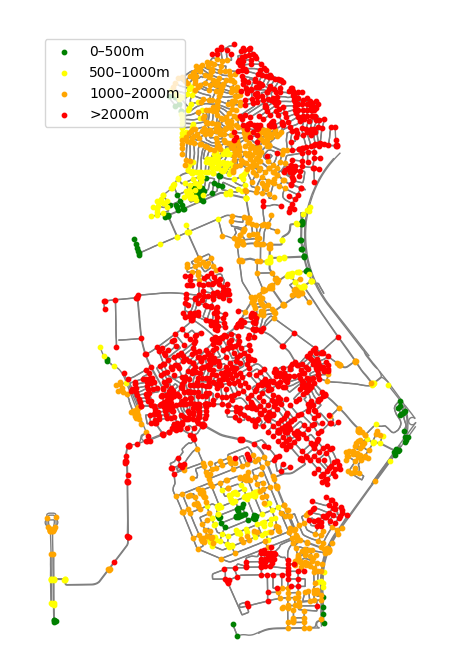

In [ ]:
fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', bgcolor='white', show=False, close=False)

# Use white instead of lime
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_0_500, node_color='green', node_size=10, label='0–500m')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_500_1000, node_color='yellow', node_size=10, label='500–1000m')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_1000_2000, node_color='orange', node_size=10, label='1000–2000m')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=safe_gt_2000, node_color='red', node_size=10, label='>2000m')

plt.title("Service Distance Bands from Legal Dumpsites (Ikeja)", fontsize=12, color='white')
plt.legend()
plt.show()

In [ ]:
# Ensure all nodes have positions before plotting
covered_by_legal_filtered = [n for n in covered_by_legal if n in pos]
covered_illegal_only_filtered = [n for n in covered_illegal_only if n in pos]
unserved_nodes_filtered = [n for n in unserved_nodes if n in pos]

In [ ]:
# Plot legal coverage
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=covered_by_legal_filtered, node_color='gold', node_size=8, label='Legal Access')

# Plot illegal-only coverage
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=covered_illegal_only_filtered, node_color='orange', node_size=8, label='Illegal-Only Access')

# Plot unserved nodes
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=unserved_nodes_filtered, node_color='red', node_size=8, label='Unserved')

✔ Using 32 illegal dumpsites for Ikeja


Computing illegal buffers: 100%|██████████| 32/32 [00:00<00:00, 355.03it/s]
<ipython-input-215-bee9e2d28e95>:73: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


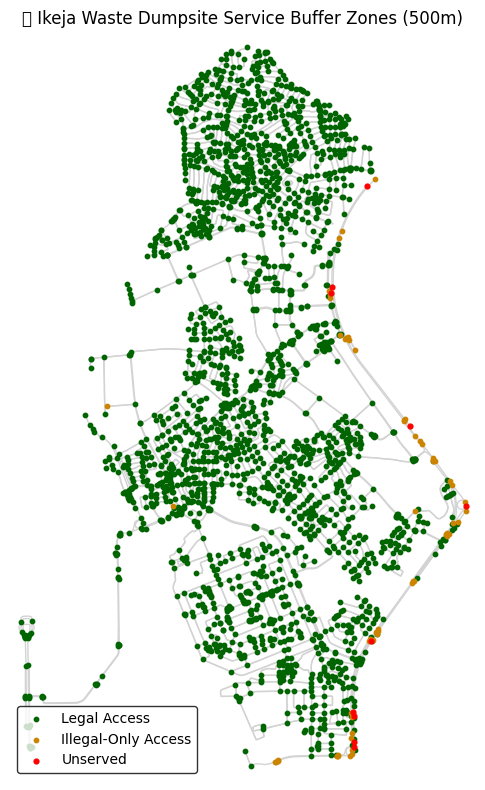

In [ ]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Load the Ikeja street network
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Step 2: Load and map illegal dumpsites to nodes
illegal_df = pd.read_excel('LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx')
illegal_nodes = [
ox.nearest_nodes(G, lon, lat)
for lat, lon in zip(illegal_df['Latitude'], illegal_df['Longitude'])
]

print(f"✔ Using {len(illegal_nodes)} illegal dumpsites for Ikeja")

# Step 3: Compute 500m buffer for illegal dumpsites
buffer_dist = 500
illegal_buffers = []
for node in tqdm(illegal_nodes, desc="Computing illegal buffers"):
reachable = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
illegal_buffers.append(set(reachable.keys()))

covered_by_illegal = set().union(*illegal_buffers)

# Step 4: Compute legal buffer (reuse your existing mapping)
# Make sure to define `legal_nodes` and `covered_by_legal` before this step
# Example:
# legal_df = pd.read_csv('legal_waste_dumpsites.csv')
# legal_nodes = [...]
# covered_by_legal = [...]

# Step 5: Define categories
all_nodes = set(G.nodes)
covered_illegal_only = covered_by_illegal - covered_by_legal
unserved_nodes = all_nodes - covered_by_legal - covered_by_illegal

# Step 6: Prepare positions and plot
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

fig, ax = ox.plot_graph(
G, node_size=0, edge_color='lightgray', bgcolor='white', show=False, close=False
)

# LEGAL: Dark green
nx.draw_networkx_nodes(G, pos=pos, ax=ax,
nodelist=[n for n in covered_by_legal if n in pos],
node_color='#006400',  # Dark green
node_size=10, label='Legal Access'
)

# ILLEGAL-ONLY: Darker orange
nx.draw_networkx_nodes(G, pos=pos, ax=ax,
nodelist=[n for n in covered_illegal_only if n in pos],
node_color='#cc8400',  # Darker orange
node_size=10, label='Illegal-Only Access'
)

# UNSERVED: Red
nx.draw_networkx_nodes(G, pos=pos, ax=ax,
nodelist=[n for n in unserved_nodes if n in pos],
node_color='red',
node_size=12, label='Unserved'
)

# Final touches
plt.title("🗺️ Ikeja Waste Dumpsite Service Buffer Zones (500m)", fontsize=12, color='black')
plt.legend(facecolor='white', edgecolor='black')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


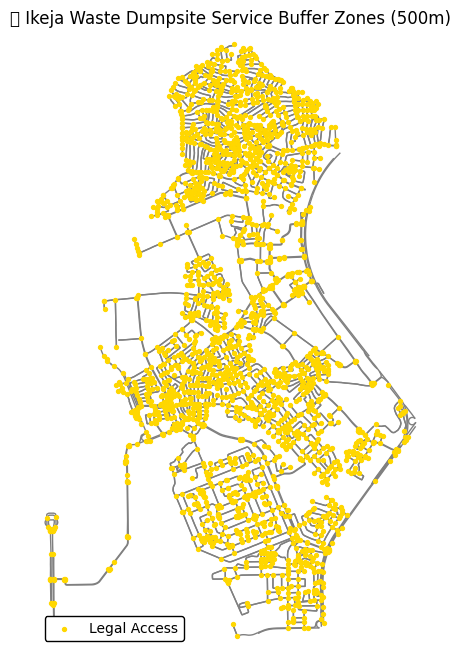

In [ ]:
import matplotlib.pyplot as plt

# Set up white background with matplotlib styling
fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', bgcolor='white', show=False, close=False)

# Plot the filtered nodes with their color-coded categories
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=covered_by_legal_filtered, node_color='gold', node_size=8, label='Legal Access')
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=covered_illegal_only_filtered, node_color='orange', node_size=8, label='Illegal-Only Access')
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=unserved_nodes_filtered, node_color='red', node_size=8, label='Unserved')

# Add title and legend
plt.title("🗺️ Ikeja Waste Dumpsite Service Buffer Zones (500m)", fontsize=12)
plt.legend(loc='lower left', facecolor='white', edgecolor='black', framealpha=1)

plt.show()

NetworkXError: Node 9391210506 has no position.

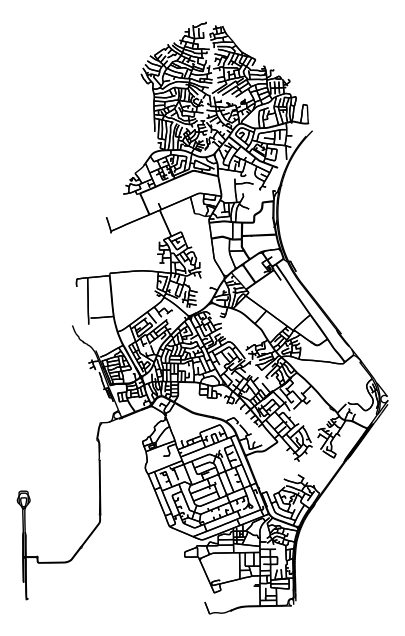

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Generate position dictionary
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot base map
fig, ax = ox.plot_graph(G, node_size=0, edge_color='black', bgcolor='white', show=False, close=False)

# Plot legal coverage (replace 'white' with 'gold' for golden yellow if preferred)
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=list(covered_by_legal), node_color='white', node_size=8, label='Legal Access')

# Plot illegal-only coverage
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=list(covered_illegal_only), node_color='orange', node_size=8, label='Illegal-Only Access')

# Plot unserved nodes
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=list(unserved_nodes), node_color='red', node_size=8, label='Unserved')

# Title and legend
plt.title("📍 Ikeja Waste Dumpsite Service Buffer Zones (500m)", fontsize=12)
plt.legend(facecolor='white')
plt.tight_layout()
plt.show()

In [ ]:
# Rebuild pos from your current graph G
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Optional safety check before plotting
nodes_to_plot = [n for n in your_node_list if n in pos]

NameError: name 'your_node_list' is not defined

NetworkXError: Node 9391210506 has no position.

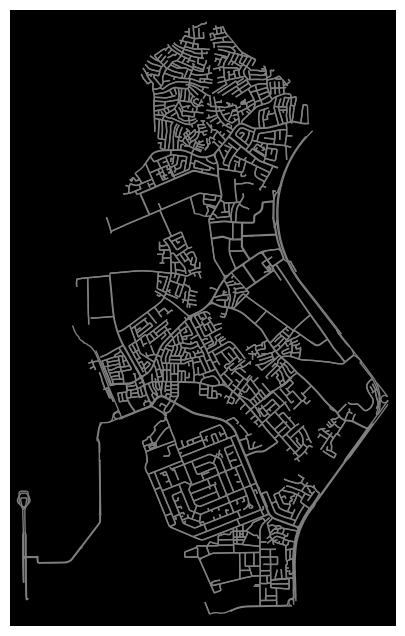

In [ ]:
from tqdm import tqdm
import numpy as np

# Step 1: Compute distance from every node to the nearest LEGAL site
min_distances = []

for node in tqdm(G.nodes(), desc="Computing distances"):
distances = []
for legal_node in legal_nodes:
try:
length = nx.shortest_path_length(G, node, legal_node, weight='length')
distances.append(length)
except:
continue
if distances:
min_distances.append((node, min(distances)))

# Step 2: Categorize nodes by distance bands
bands = {
'0–500m': [],
'500–1000m': [],
'1000–2000m': [],
'>2000m': []
}

for node, dist in min_distances:
if dist <= 500:
bands['0–500m'].append(node)
elif dist <= 1000:
bands['500–1000m'].append(node)
elif dist <= 2000:
bands['1000–2000m'].append(node)
else:
bands['>2000m'].append(node)

# Step 3: Show results
for label, nodes in bands.items():
print(f"{label}: {len(nodes)} nodes ({(len(nodes)/len(G.nodes))*100:.2f}%)")

Computing distances: 100%|██████████| 5969/5969 [1:13:18<00:00,  1.36it/s]

0–500m: 327 nodes (5.48%)
500–1000m: 837 nodes (14.02%)
1000–2000m: 2147 nodes (35.97%)
>2000m: 2658 nodes (44.53%)


In [ ]:
# Rebuild pos from your current graph G
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Optional safety check before plotting
nodes_to_plot = [n for n in your_node_list if n in pos]

NameError: name 'your_node_list' is not defined

Mapping illegal dumpsites to nearest nodes...
✔ Using 32 illegal dumpsites for Ikeja


100%|██████████| 32/32 [00:00<00:00, 322.06it/s]


NetworkXError: Node 9391210506 has no position.

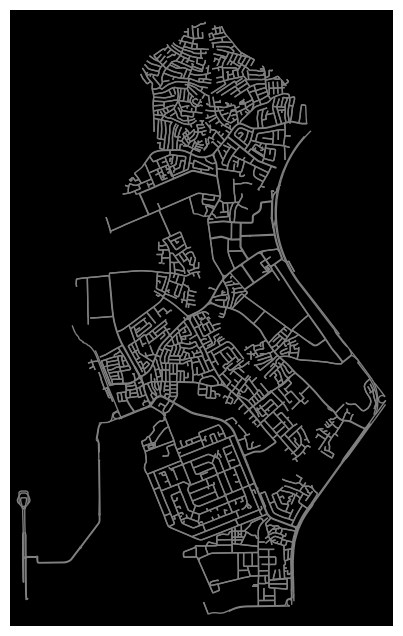

In [ ]:
import networkx as nx
import osmnx as ox
import pandas as pd
from tqdm import tqdm

# Load your street network again (in case it was modified)
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Load the correct illegal dumpsite coordinates
illegal_df = pd.read_excel('LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx')  # adjust path if needed

# Filter for only Ikeja-relevant entries (optional if already pre-filtered)
# illegal_df = illegal_df[illegal_df['Address'].str.contains("Ikeja", na=False)]

# Map to nearest nodes in the network
print("Mapping illegal dumpsites to nearest nodes...")
illegal_nodes = [
ox.nearest_nodes(G, lon, lat)
for lat, lon in zip(illegal_df['Latitude'], illegal_df['Longitude'])
]

# Confirm we're using only the actual number of locations
print(f"✔ Using {len(illegal_nodes)} illegal dumpsites for Ikeja")

# Recalculate buffers
buffer_dist = 500  # in meters
illegal_buffers = []
for node in tqdm(illegal_nodes):
reachable_nodes = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
illegal_buffers.append(set(reachable_nodes.keys()))

# Combine all covered nodes
covered_by_illegal = set().union(*illegal_buffers)

# Recalculate legal buffer nodes as you already have done
# Assuming `legal_nodes` and `covered_by_legal` are already computed correctly

# Identify classification
all_nodes = set(G.nodes)
covered_illegal_only = covered_by_illegal - covered_by_legal
unserved_nodes = all_nodes - covered_by_legal - covered_by_illegal

# Now plot fresh access map
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(
G, node_size=0, edge_color='gray', bgcolor='black', show=False, close=False
)

pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=list(covered_by_legal), node_color='green', node_size=8, label='Legal Access')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=list(covered_illegal_only), node_color='orange', node_size=8, label='Illegal-Only Access')
nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=list(unserved_nodes), node_color='red', node_size=12, label='Unserved')

plt.title("Ikeja Waste Service Coverage (Corrected, 500m Buffer)", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white')
plt.show()

✔ Using 32 illegal dumpsites for Ikeja


100%|██████████| 32/32 [00:00<00:00, 343.04it/s]
<ipython-input-213-9afe4405d713>:70: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


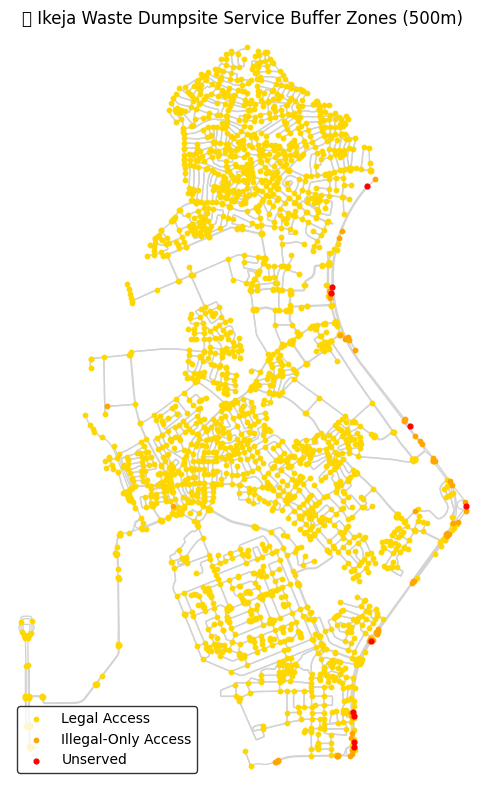

In [ ]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Load Network and Street Graph
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Step 2: Load and Map Illegal Dumpsites to Nodes
illegal_df = pd.read_excel('LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx')
illegal_nodes = [
ox.nearest_nodes(G, lon, lat)
for lat, lon in zip(illegal_df['Latitude'], illegal_df['Longitude'])
]

print(f"✔ Using {len(illegal_nodes)} illegal dumpsites for Ikeja")

# Step 3: Compute Buffers
buffer_dist = 500
illegal_buffers = []
for node in tqdm(illegal_nodes):
reachable = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
illegal_buffers.append(set(reachable.keys()))

covered_by_illegal = set().union(*illegal_buffers)

# Step 4: Reuse existing legal buffer results
# You must ensure these are already computed somewhere:
# legal_nodes and covered_by_legal
# For safety, re-map them here if needed
# Example:
# legal_df = pd.read_csv('legal_waste_dumpsites.csv')
# legal_nodes = [...]
# covered_by_legal = [...]

# Step 5: Compute Accessibility Classes
all_nodes = set(G.nodes)
covered_illegal_only = covered_by_illegal - covered_by_legal
unserved_nodes = all_nodes - covered_by_legal - covered_by_illegal

# Step 6: Visualize — White Background, Yellow/Red/Orange Nodes
fig, ax = ox.plot_graph(G, node_size=0, edge_color='lightgray', bgcolor='white', show=False, close=False)

# Prepare node positions
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Draw categorized nodes
nx.draw_networkx_nodes(G, pos=pos, ax=ax,
nodelist=[n for n in covered_by_legal if n in pos],
node_color='#FFD700',  # Golden Yellow
node_size=10, label='Legal Access'
)
nx.draw_networkx_nodes(G, pos=pos, ax=ax,
nodelist=[n for n in covered_illegal_only if n in pos],
node_color='orange',
node_size=10, label='Illegal-Only Access'
)
nx.draw_networkx_nodes(G, pos=pos, ax=ax,
nodelist=[n for n in unserved_nodes if n in pos],
node_color='red',
node_size=12, label='Unserved'
)

# Title and Legend
plt.title("🗺️ Ikeja Waste Dumpsite Service Buffer Zones (500m)", fontsize=12, color='black')
plt.legend(facecolor='white', edgecolor='black')
plt.tight_layout()
plt.show()

In [ ]:
illegal_df.columns

Index(['Name', 'Latitude', 'Longitude', 'Reference Link'], dtype='object')

In [ ]:
print(illegal_df.columns.tolist())

['Name', 'Latitude', 'Longitude', 'Reference Link']


In [ ]:
illegal_df_ikeja = illegal_df[illegal_df['Name'].str.contains("Ikeja", case=False)]

In [ ]:
legal_df_ikeja = legal_df[legal_df['Name'].str.contains("Ikeja", case=False)]

In [ ]:
# Define a helper function to get nearest network nodes for a DataFrame
def get_nearest_nodes(df, lat_col, lon_col):
return ox.distance.nearest_nodes(G, X=df[lon_col].values, Y=df[lat_col].values)

In [ ]:
illegal_nodes = get_nearest_nodes(illegal_df_ikeja, 'Latitude', 'Longitude')

In [ ]:
legal_nodes = get_nearest_nodes(legal_df_ikeja, 'Latitude', 'Longitude')

In [ ]:
from tqdm import tqdm
import networkx as nx

buffer_dist = 500  # in meters

# Compute legal coverage
covered_by_legal = set()
for node in tqdm(legal_nodes, desc="Legal Coverage"):
paths = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
covered_by_legal.update(paths.keys())

# Compute illegal coverage
covered_by_illegal = set()
for node in tqdm(illegal_nodes, desc="Illegal Coverage"):
paths = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer_dist)
covered_by_illegal.update(paths.keys())

# Find underserved nodes (not covered by either)
all_nodes = set(G.nodes)
unserved_nodes = all_nodes - covered_by_legal - covered_by_illegal

Illegal Coverage: 100%|██████████| 1/1 [00:00<00:00, 1725.34it/s]


In [ ]:
import matplotlib.pyplot as plt

# Make sure node positions are available
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Create the figure
fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', bgcolor='black', show=False, close=False)

# Plot unserved nodes in red
nx.draw_networkx_nodes(
G, pos=pos, ax=ax,
nodelist=list(gdf_unserved_latlon['node']),
node_color='red', node_size=40,
label='Unserved Nodes'
)

# Optionally annotate a few with street names
for _, row in gdf_unserved_latlon.iterrows():
x, y = G.nodes[row['node']]['x'], G.nodes[row['node']]['y']
ax.text(x, y + 5, row['street_name'], fontsize=6, color='white')

# Title and legend
plt.title("Underserved Locations in Ikeja (With Nearest Street Labels)", fontsize=12, color='white')
plt.legend(facecolor='black', edgecolor='white')
plt.tight_layout()
plt.show()

In [ ]:
from shapely.geometry import Point
import geopandas as gpd

# Get list of Points for each unserved node
unserved_points = [Point(G.nodes[n]['x'], G.nodes[n]['y']) for n in unserved_nodes]

# Create GeoDataFrame of unserved nodes
gdf_unserved = gpd.GeoDataFrame({'node': list(unserved_nodes)}, geometry=unserved_points, crs=G.graph['crs'])

# Reproject to WGS84 for geocoding
gdf_unserved_latlon = gdf_unserved.to_crs("EPSG:4326")
gdf_unserved_latlon['latitude'] = gdf_unserved_latlon.geometry.y
gdf_unserved_latlon['longitude'] = gdf_unserved_latlon.geometry.x

100%|██████████| 25/25 [00:00<00:00, 44.27it/s]


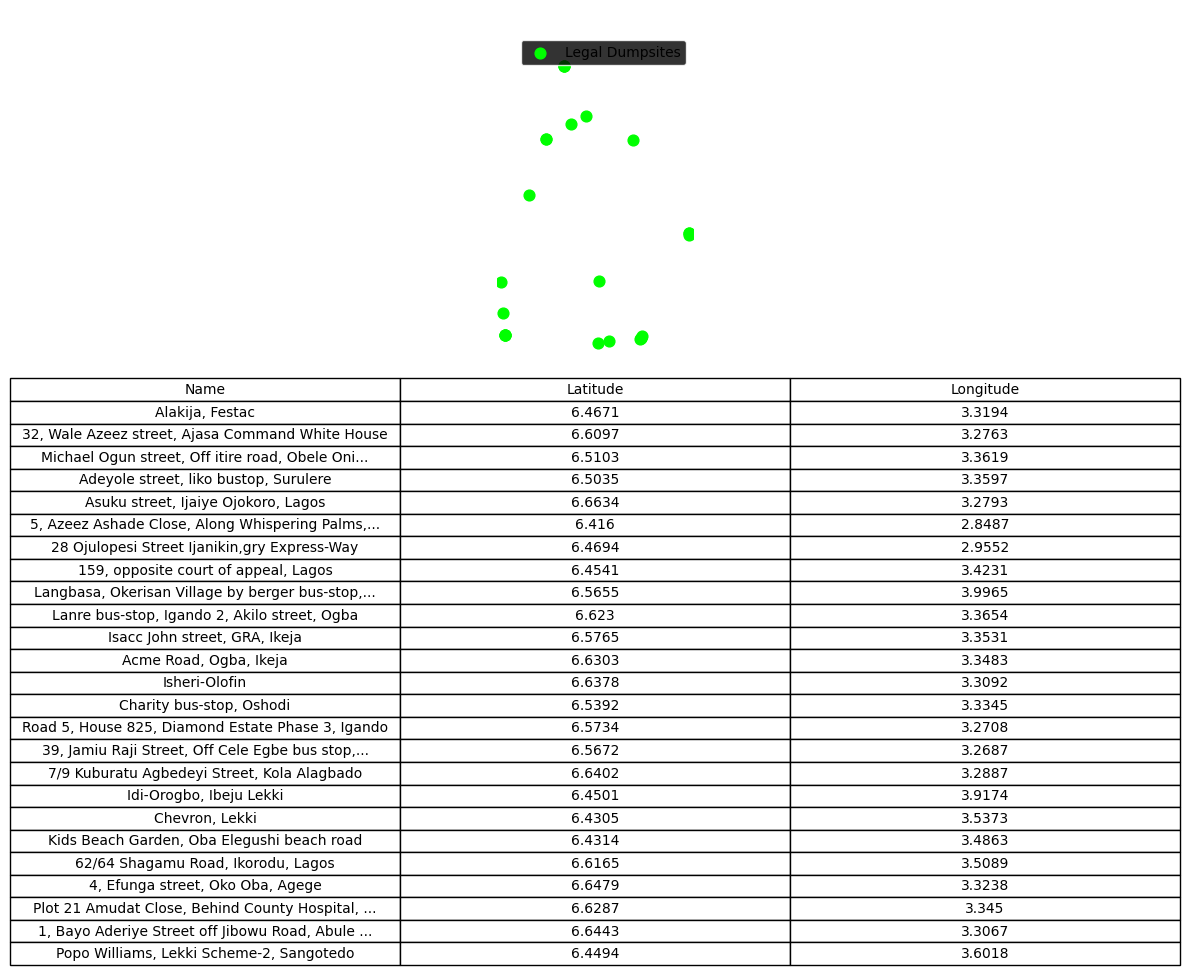

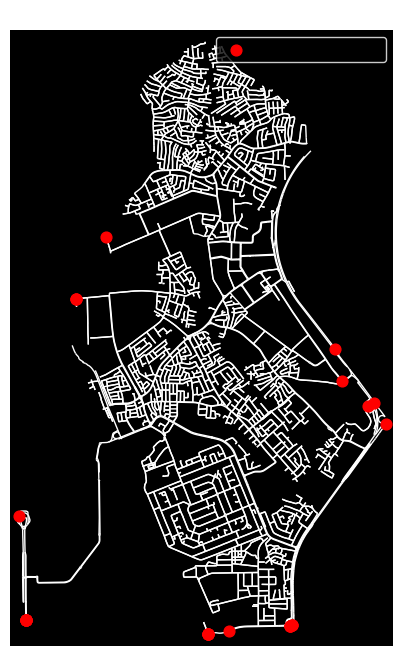

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load Ikeja street network
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')

# Load verified illegal dumpsites
illegal_df = pd.read_excel("LAGOS STATE ILLEGAL WASTE DUMPSITE.xlsx")
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm

# Load Ikeja street network
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')

# Load legal dumpsite data
legal_df = pd.read_csv('legal_waste_dumpsites.csv')

# Snap dumpsite locations to the nearest street node
tqdm.pandas()
legal_df['nearest_node'] = legal_df.progress_apply(
lambda row: ox.nearest_nodes(G, row['Longitude'], row['Latitude']), axis=1
)

# Get node positions
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# ---- PLOT with TABLE ----
fig = plt.figure(figsize=(12, 10))

# 1. Map plot
ax1 = fig.add_subplot(2, 1, 1)
ox.plot_graph(
G, ax=ax1, node_size=0, edge_color='white',
bgcolor='black', show=False, close=False
)
nx.draw_networkx_nodes(
G, pos=pos, ax=ax1,
nodelist=legal_df['nearest_node'].tolist(),
node_color='lime', node_size=60, label='Legal Dumpsites'
)
ax1.set_title("Legal Waste Dumpsites in Ikeja", fontsize=14, color='white')
ax1.legend(loc='upper right', facecolor='black', edgecolor='white')

# 2. Table subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.axis('off')  # Hide axes
table_data = legal_df[['Name', 'Latitude', 'Longitude']]
table = ax2.table(cellText=table_data.values,
colLabels=table_data.columns,
loc='center',
cellLoc='center')
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.tight_layout()
plt.show()

# Get nearest graph nodes for each illegal site
illegal_nodes = [
ox.nearest_nodes(G, lon, lat)
for lat, lon in zip(illegal_df['Latitude'], illegal_df['Longitude'])
]

# Plot map
fig, ax = ox.plot_graph(G, node_size=0, edge_color='white', bgcolor='black', show=False, close=False)

# Build node position dictionary
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Draw illegal waste site nodes
nx.draw_networkx_nodes(
G, pos=pos, ax=ax,
nodelist=illegal_nodes,
node_color='red',
node_size=60,
label='Illegal Dumpsites'
)

plt.title("Illegal Waste Dumpsite Locations (Ikeja)", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white')
plt.show()

100%|██████████| 25/25 [00:00<00:00, 58.27it/s]


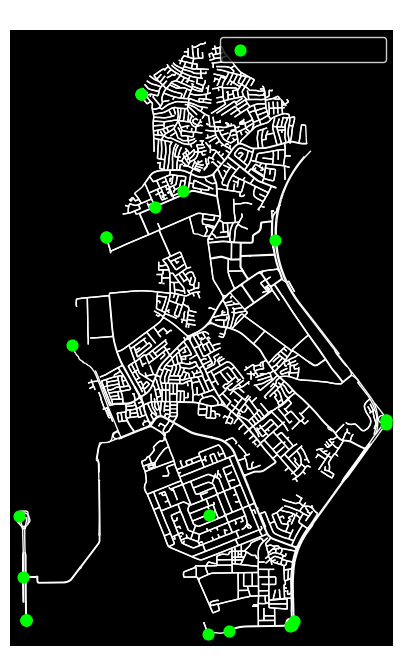

In [ ]:
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Load legal dumpsite coordinates
legal_df = pd.read_csv('legal_waste_dumpsites.csv')  # Ensure this is the correct file

# Step 2: Load the Ikeja road network
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')

# Step 3: Snap legal site coordinates to nearest street network nodes
tqdm.pandas()
legal_nodes = legal_df.progress_apply(lambda row: ox.nearest_nodes(G, row['Longitude'], row['Latitude']), axis=1)

# Step 4: Plot only legal waste dumpsites
fig, ax = ox.plot_graph(G, node_size=0, edge_color='white', bgcolor='black', show=False, close=False)

# Get node coordinates (positions)
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Draw legal dumpsite nodes
nx.draw_networkx_nodes(
G, pos=pos, ax=ax,
nodelist=legal_nodes.tolist(),
node_color='lime',
node_size=60,
label='Legal Dumpsites'
)

plt.title("Legal Waste Dumpsite Locations in Ikeja", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white')
plt.show()

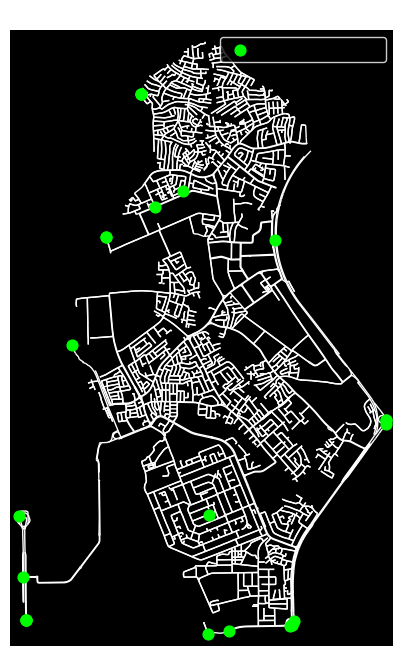

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load the Ikeja street network
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')

# Load verified legal dumpsite data (CSV format)
legal_df = pd.read_csv('legal_waste_dumpsites.csv')  # Adjust path if necessary

# Map each legal site to its nearest network node
legal_nodes = [
ox.nearest_nodes(G, lon, lat)
for lat, lon in zip(legal_df['Latitude'], legal_df['Longitude'])
]

# Plot base street network
fig, ax = ox.plot_graph(G, node_size=0, edge_color='white', bgcolor='black', show=False, close=False)

# Get node positions
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot legal dumpsite nodes
nx.draw_networkx_nodes(
G, pos=pos, ax=ax,
nodelist=legal_nodes,
node_color='lime',
node_size=60,
label='Legal Dumpsites'
)

plt.title("Legal Waste Dumpsite Locations (Ikeja)", fontsize=11, color='white')
plt.legend(facecolor='black', edgecolor='white')
plt.show()

100%|██████████| 25/25 [00:00<00:00, 80.47it/s]


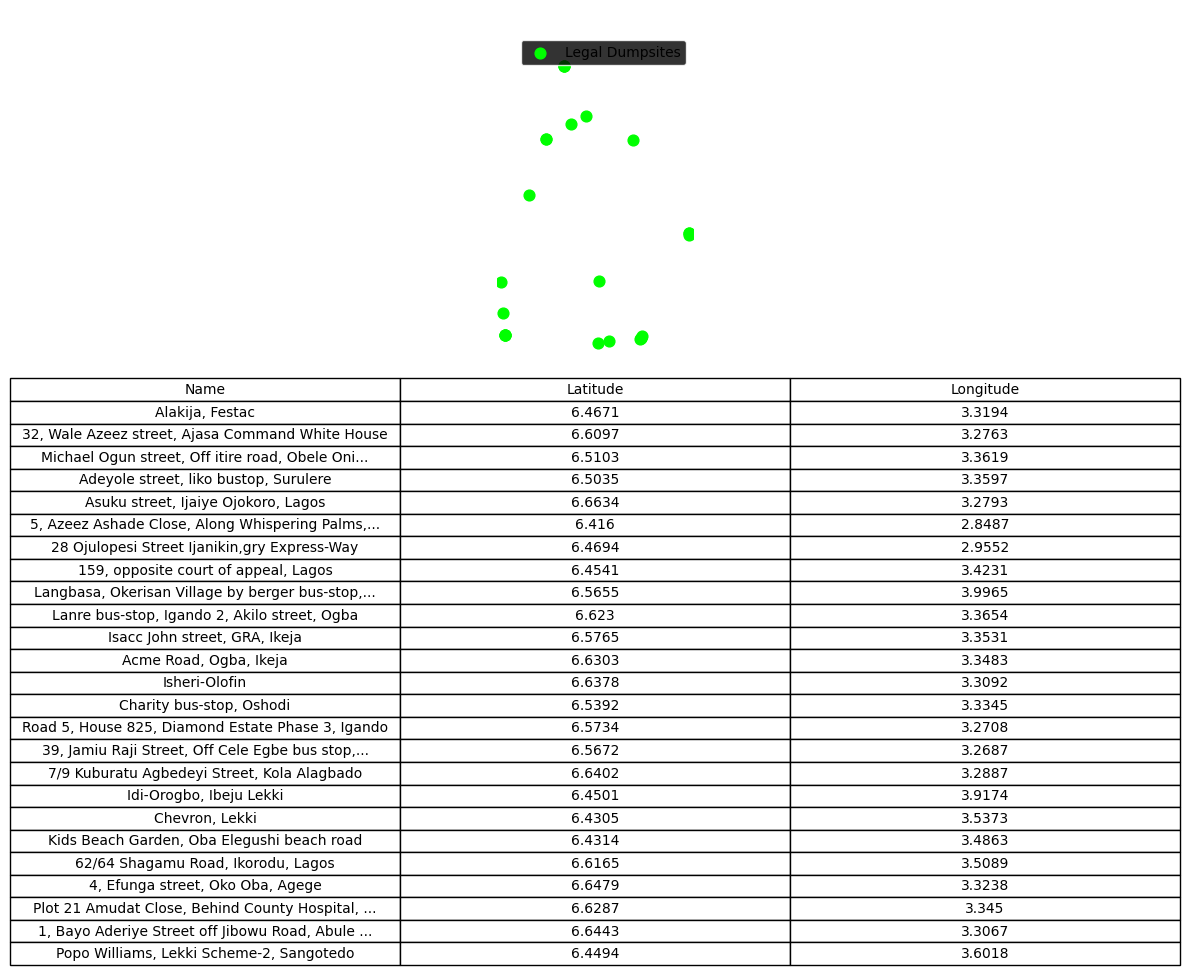

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm

# Load Ikeja street network
G = ox.graph_from_place('Ikeja, Lagos, Nigeria', network_type='drive')

# Load legal dumpsite data
legal_df = pd.read_csv('legal_waste_dumpsites.csv')

# Snap dumpsite locations to the nearest street node
tqdm.pandas()
legal_df['nearest_node'] = legal_df.progress_apply(
lambda row: ox.nearest_nodes(G, row['Longitude'], row['Latitude']), axis=1
)

# Get node positions
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# ---- PLOT with TABLE ----
fig = plt.figure(figsize=(12, 10))

# 1. Map plot
ax1 = fig.add_subplot(2, 1, 1)
ox.plot_graph(
G, ax=ax1, node_size=0, edge_color='white',
bgcolor='black', show=False, close=False
)
nx.draw_networkx_nodes(
G, pos=pos, ax=ax1,
nodelist=legal_df['nearest_node'].tolist(),
node_color='lime', node_size=60, label='Legal Dumpsites'
)
ax1.set_title("Legal Waste Dumpsites in Ikeja", fontsize=14, color='white')
ax1.legend(loc='upper right', facecolor='black', edgecolor='white')

# 2. Table subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.axis('off')  # Hide axes
table_data = legal_df[['Name', 'Latitude', 'Longitude']]
table = ax2.table(cellText=table_data.values,
colLabels=table_data.columns,
loc='center',
cellLoc='center')
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.tight_layout()
plt.show()

In [ ]:
!pip install osmnx networkx geopandas shapely matplotlib folium tqdm

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Define the area
place = "Ikeja, Lagos, Nigeria"
G = ox.graph_from_place(place, network_type='walk')
nodes, edges = ox.graph_to_gdfs(G)

In [ ]:
# Convert to GeoDataFrames
legal_gdf = gpd.GeoDataFrame(legal_df, geometry=gpd.points_from_xy(legal_df.Longitude, legal_df.Latitude), crs='EPSG:4326')
illegal_gdf = gpd.GeoDataFrame(illegal_df, geometry=gpd.points_from_xy(illegal_df.Longitude, illegal_df.Latitude), crs='EPSG:4326')

# Project to the same CRS as street network
legal_gdf = legal_gdf.to_crs(nodes.crs)
illegal_gdf = illegal_gdf.to_crs(nodes.crs)

In [ ]:
from shapely.geometry import Point

def get_nearest_nodes(gdf, G_proj):
return [ox.distance.nearest_nodes(G_proj, point.x, point.y) for point in gdf.geometry]

legal_nodes = get_nearest_nodes(legal_gdf, G)
illegal_nodes = get_nearest_nodes(illegal_gdf, G)

In [ ]:
def compute_service_areas(G, source_nodes, buffer=500):
buffers = []
for node in tqdm(source_nodes):
nearby = nx.single_source_dijkstra_path_length(G, node, cutoff=buffer)
buffers.append(set(nearby.keys()))
return buffers

legal_buffers = compute_service_areas(G, legal_nodes)
illegal_buffers = compute_service_areas(G, illegal_nodes)

# Flatten for classification
covered_by_legal = set().union(*legal_buffers)
covered_by_illegal = set().union(*illegal_buffers)

covered_illegal_only = covered_by_illegal - covered_by_legal
unserved_nodes = set(G.nodes) - (covered_by_legal | covered_by_illegal)

100%|██████████| 32/32 [00:00<00:00, 32.24it/s]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


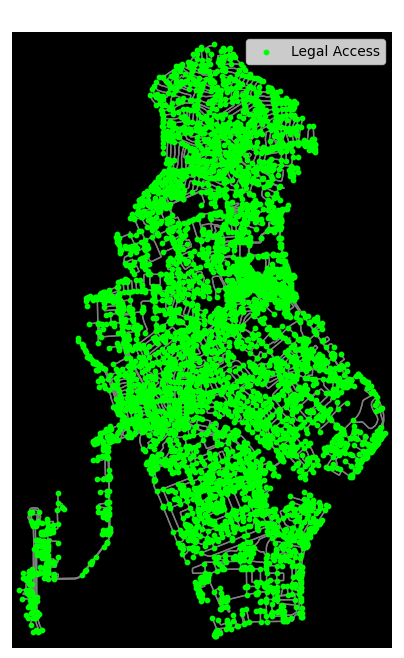

In [ ]:
# Extract positions of nodes
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Plot base street network
fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', bgcolor='black', show=False, close=False)

# Overlay node access types
nx.draw_networkx_nodes(G, ax=ax, pos=pos, nodelist=list(covered_by_legal), node_color='lime', node_size=10, label='Legal Access')
nx.draw_networkx_nodes(G, ax=ax, pos=pos, nodelist=list(covered_illegal_only), node_color='orange', node_size=10, label='Illegal-Only Access')
nx.draw_networkx_nodes(G, ax=ax, pos=pos, nodelist=list(unserved_nodes), node_color='red', node_size=10, label='Unserved')

# Final plot adjustments
plt.title("🗺️ Ikeja Waste Service Coverage (500m Buffer)", fontsize=12, color='white')
plt.legend()
plt.show()